In [1]:

# imports
import os
import sys
import types
import json

# figure size/format
fig_width = 7
fig_height = 5
fig_format = 'retina'
fig_dpi = 96

# matplotlib defaults / format
try:
  import matplotlib.pyplot as plt
  plt.rcParams['figure.figsize'] = (fig_width, fig_height)
  plt.rcParams['figure.dpi'] = fig_dpi
  plt.rcParams['savefig.dpi'] = fig_dpi
  from IPython.display import set_matplotlib_formats
  set_matplotlib_formats(fig_format)
except Exception:
  pass

# plotly use connected mode
try:
  import plotly.io as pio
  pio.renderers.default = "notebook_connected"
except Exception:
  pass

# enable pandas latex repr when targeting pdfs
try:
  import pandas as pd
  if fig_format == 'pdf':
    pd.set_option('display.latex.repr', True)
except Exception:
  pass



# output kernel dependencies
kernel_deps = dict()
for module in list(sys.modules.values()):
  # Some modules play games with sys.modules (e.g. email/__init__.py
  # in the standard library), and occasionally this can cause strange
  # failures in getattr.  Just ignore anything that's not an ordinary
  # module.
  if not isinstance(module, types.ModuleType):
    continue
  path = getattr(module, "__file__", None)
  if not path:
    continue
  if path.endswith(".pyc") or path.endswith(".pyo"):
    path = path[:-1]
  if not os.path.exists(path):
    continue
  kernel_deps[path] = os.stat(path).st_mtime
print(json.dumps(kernel_deps))

# set run_path if requested
if r'/Users/heiletjevanzyl/Desktop/DSFI/STA5073Z Assignment 2/ds4i-assignment2-code':
  os.chdir(r'/Users/heiletjevanzyl/Desktop/DSFI/STA5073Z Assignment 2/ds4i-assignment2-code')

# reset state
%reset

def ojs_define(**kwargs):
  import json
  try:
    # IPython 7.14 preferred import
    from IPython.display import display, HTML
  except:
    from IPython.core.display import display, HTML

  # do some minor magic for convenience when handling pandas
  # dataframes
  def convert(v):
    try:
      import pandas as pd
    except ModuleNotFoundError: # don't do the magic when pandas is not available
      return v
    if type(v) == pd.Series:
      v = pd.DataFrame(v)
    if type(v) == pd.DataFrame:
      j = json.loads(v.T.to_json(orient='split'))
      return dict((k,v) for (k,v) in zip(j["index"], j["data"]))
    else:
      return v
  
  v = dict(contents=list(dict(name=key, value=convert(value)) for (key, value) in kwargs.items()))
  display(HTML('<script type="ojs-define">' + json.dumps(v) + '</script>'), metadata=dict(ojs_define = True))
globals()["ojs_define"] = ojs_define


/var/folders/km/sfmlc74j2sqgqqnyck0zzymm0000gn/T/ipykernel_68709/3876375721.py:20: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats(fig_format)


{"/Users/heiletjevanzyl/anaconda3/lib/python3.11/importlib/_bootstrap.py": 1694439389.41593, "/Users/heiletjevanzyl/anaconda3/lib/python3.11/importlib/_bootstrap_external.py": 1694439389.4256217, "/Users/heiletjevanzyl/anaconda3/lib/python3.11/zipimport.py": 1694439385.7741373, "/Users/heiletjevanzyl/anaconda3/lib/python3.11/codecs.py": 1694439384.781692, "/Users/heiletjevanzyl/anaconda3/lib/python3.11/encodings/aliases.py": 1694439387.126954, "/Users/heiletjevanzyl/anaconda3/lib/python3.11/encodings/__init__.py": 1694439387.119218, "/Users/heiletjevanzyl/anaconda3/lib/python3.11/encodings/utf_8.py": 1694439388.3518095, "/Users/heiletjevanzyl/anaconda3/lib/python3.11/abc.py": 1694439384.644435, "/Users/heiletjevanzyl/anaconda3/lib/python3.11/io.py": 1694439385.0425074, "/Users/heiletjevanzyl/anaconda3/lib/python3.11/stat.py": 1694439385.5135145, "/Users/heiletjevanzyl/anaconda3/lib/python3.11/_collections_abc.py": 1694439384.5167792, "/Users/heiletjevanzyl/anaconda3/lib/python3.11/gene

In [2]:
# Loading in the necessary libraries
import zipfile
import os
import pandas as pd
import re
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS
from itertools import cycle
import seaborn as sns
import numpy as np
from collections import Counter
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import wordnet, stopwords, words
from nltk.stem import WordNetLemmatizer
from ast import literal_eval
from collections import defaultdict


In [3]:
# Unzip the file and get the list of filenames
with zipfile.ZipFile("data/speeches.zip", 'r') as zip_ref:
    zip_ref.extractall("data")

filenames = os.listdir("data")
filenames = [filename for filename in filenames if filename.endswith('.txt')]

# Read the content of each speech file and extract the date from the first line
speeches = []
dates = []
for filename in filenames:
    with open(os.path.join("data", filename), 'r', encoding='utf-8') as file:
        # Extract date from the first line
        date = file.readline().strip()
        dates.append(date)
        
        # Read the rest of the file
        speeches.append(file.read())

# Create DataFrame
sona = pd.DataFrame({'filename': filenames, 'speech': speeches, 'date': dates})

# Extract year and president for each speech
sona['year'] = sona['filename'].str[:4]
sona['president'] = sona['filename'].str.split('_').str[-1].str.split('.').str[0]

# Clean the sona dataset by removing unnecessary text
replace_reg = r'(http.*?(\s|.$))|(www.*?(\s|.$))|&amp;|&lt;|&gt;|\n'
sona['speech'] = sona['speech'].str.replace(replace_reg, ' ')

# Split speeches into sentences
sona_sentences = sona.copy()

import itertools

# Replace new lines with space and split into sentences based on regular expression
sona_sentences['speech'] = sona_sentences['speech'].str.replace('\n', ' ').str.split(r'(?<!\w\.\w.)(?<![A-Z][a-z]\.)(?<=\.|\?)\s')

# Flatten the list of sentence fragments to avoid nested lists
sona_sentences['speech'] = sona_sentences['speech'].apply(lambda sentences: list(itertools.chain.from_iterable(sentence.split('.') for sentence in sentences)))

# Remove empty strings from the list of sentences
sona_sentences['speech'] = sona_sentences['speech'].apply(lambda sentences: [sentence.strip() for sentence in sentences if sentence.strip()])

# Make a csv of the speeches
sona.to_csv('data/sona_speeches.csv', index=False)

# Make a csv of the sentences
sona_sentences.to_csv('data/sona_sentences_untransformed.csv', index=False)

In [4]:
# Make sure to download the necessary NLTK corpus if you haven't already
#nltk.download('wordnet')
#nltk.download('averaged_perceptron_tagger')
#nltk.download('words')

# Read in the sona speeches dataset
sona_speeches_df = pd.read_csv('data/sona_speeches.csv')
sona_sentences_clean = pd.read_csv('data/sona_sentences_untransformed.csv')
sona_sentences_clean['speech'] = sona_sentences_clean['speech'].apply(literal_eval)

# Initialize the WordNetLemmatizer
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))
english_words = set(words.words())
additional_words = {
    'honourable', 'member', 'chairperson',
    'south', 'africa', 'african', 'africans', 'year',
    'madame', 'madam', 'soes', 'ms', 'madams', 'madames', 'mw',
    'compatriotsthe',
    'also'
}

# Function to convert NLTK's part-of-speech tags to WordNet's part-of-speech tags
def get_wordnet_pos(word):
    """Map NLTK part of speech tags to WordNet part of speech tags."""
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": nltk.corpus.wordnet.ADJ,
                "N": nltk.corpus.wordnet.NOUN,
                "V": nltk.corpus.wordnet.VERB,
                "R": nltk.corpus.wordnet.ADV}

    return tag_dict.get(tag, nltk.corpus.wordnet.NOUN)

# Clean the text, convert to lowercase, and lemmatize each word
def clean_text(text):
    # Remove special characters: keep only letters, numbers, and basic punctuation
    text = re.sub(r'[.;]', ' ', text)  # Replaces periods with spaces
    text = re.sub(r'[^a-zA-Z ]', '', text)
    text = text.lower()  # Convert to lowercase
    
    # Tokenize the text
    words = word_tokenize(text)
    
    # Remove stop words
    words = [word for word in words if word not in stop_words]
    
    # Remove additional words
    words = [word for word in words if word not in additional_words]

    # Lemmatize each word with the correct POS tag
    lemmatized_words = []
    for word, tag in nltk.pos_tag(words):
        wntag = get_wordnet_pos(tag)
        lemmatized_word = lemmatizer.lemmatize(word, wntag)
        # Only append the lemmatized word if it is in the set of English words
        if lemmatized_word in english_words:
            lemmatized_words.append(lemmatized_word)
    
    # Join the lemmatized words back into one string
    text = ' '.join(words)
    return text

def clean_text_no_word_removals(text):
    # Remove special characters: keep only letters, numbers, and basic punctuation
    text = re.sub(r'[.;]', ' ', text)  # Replaces periods with spaces
    text = re.sub(r'[^a-zA-Z ]', '', text)
    text = text.lower()  # Convert to lowercase
    return text

# Apply the cleaning function to the speech column
tempdf = sona_speeches_df.copy()
sona_speeches_df['speech'] = tempdf['speech'].apply(clean_text)
sona_speeches_df['speech_untrans'] = tempdf['speech'].apply(clean_text_no_word_removals)

def clean_speeches(speeches):
    # The input is expected to be a list of strings
    return [clean_text(sentence) for sentence in speeches]

# Apply the cleaning to the sentences too
sona_sentences_clean['sentence'] = sona_sentences_clean['speech'].apply(lambda speeches: [clean_text(sentence) for sentence in speeches])

# Apply the cleaning to sentences that need to keep their words
sona_sentences_clean['sent_untrans'] = sona_sentences_clean['speech'].apply(lambda speeches: [clean_text_no_word_removals(sentence) for sentence in speeches])

# Make a csv of the speeches
sona_speeches_df.to_csv('data/sona_speeches_adapted.csv', index=False)

# Remove the speech column from the sentences DataFrame
sona_sentences_clean.drop(columns=['speech'], inplace=True)

# Make a csv of the sentences
sona_sentences_clean.to_csv('data/sona_sentences_clean.csv', index=False)

In [5]:
sona_sentences_clean = pd.read_csv('data/sona_sentences_clean.csv')
sona_sentences_clean['sentence'] = sona_sentences_clean['sentence'].apply(literal_eval)
sona_sentences_clean['sent_untrans'] = sona_sentences_clean['sent_untrans'].apply(literal_eval)

# Make the sentences into a single column
sona_sentences_alltogether = sona_sentences_clean.explode('sentence')
sona_sentences_all_untrans = sona_sentences_clean.explode('sent_untrans')

# Drop the other columns
sona_sentences_alltogether.drop(columns=['sent_untrans'], inplace=True)
sona_sentences_all_untrans.drop(columns=['sentence'], inplace=True)

# Make a csv of the sentences
sona_sentences_all_untrans.to_csv('data/sona_sentiment_sentences.csv', index=False)

# Speeches
sona_speeches_clean = pd.read_csv('data/sona_speeches_adapted.csv')

In [6]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

max_features = 2000

bow_vectorizer = CountVectorizer(max_features=max_features)
tfidf_vectorizer = TfidfVectorizer(max_features=max_features)

# Transformed on the words
bow_matrix_words = bow_vectorizer.fit_transform(sona_speeches_clean['speech'])
tfidf_matrix_words = tfidf_vectorizer.fit_transform(sona_speeches_clean['speech'])


In [7]:
from matplotlib.colors import LinearSegmentedColormap

cmap = plt.cm.cividis

norm = plt.Normalize(0, 100)

# Define a colour map based on cividis
# Define a new colormap using a smaller slice of the cividis colormap, this time stopping well before the yellows
cividis_modified = cmap(np.linspace(0, 0.4, cmap.N))  # Using only 40% of the colormap range

# Create a new colormap from the data
cividis_no_yellow_light = LinearSegmentedColormap.from_list('cividis_no_yellow_light', cividis_modified)

# Let's pick three colors from the modified colormap
colormap = [cividis_no_yellow_light(norm(0)), 
          cividis_no_yellow_light(norm(50)), 
          cividis_no_yellow_light(norm(100))]

In [8]:
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from collections import Counter
import matplotlib.pyplot as plt

# Function to count words in speeches excluding stopwords
def get_word_frequencies(speeches, stopwords):
    word_counts = Counter()
    for speech in speeches:
        words = speech.lower().split()
        # Remove stopwords from the count
        words = [word.strip('.,!?"\'-()') for word in words if word.strip('.,!?"\'-()') not in stopwords]
        word_counts.update(words)
    return word_counts

# Get the word frequencies excluding stopwords
word_frequencies = get_word_frequencies(sona_speeches_clean['speech'], ENGLISH_STOP_WORDS)

# Get the top 10 most frequent words across all speeches
top_10_words = word_frequencies.most_common(10)

In [9]:
# Plotting
plt.figure(figsize=(10, 6))
plt.bar([word for word, count in top_10_words], [count for word, count in top_10_words], color=colormap[2])
plt.xlabel('Words', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xticks(rotation=45)

# Save the plot as a PNG file
plt.savefig(f'saved_plots/overall_top_words.png', bbox_inches='tight')
plt.close()  # Close the figure to avoid displaying it in the notebook

In [10]:
# Function to get top N frequent words for each president
def get_top_words_by_president(speeches_df, n, stopwords):
    presidents = speeches_df['president'].unique()
    top_words_by_president = {}
    for president in presidents:
        president_speeches = speeches_df[speeches_df['president'] == president]['speech']
        word_frequencies = get_word_frequencies(president_speeches, stopwords)
        top_words_by_president[president] = word_frequencies.most_common(n)
    return top_words_by_president

# Get the top 10 most frequent words for each president
top_10_words_by_president = get_top_words_by_president(sona_speeches_clean, 10, ENGLISH_STOP_WORDS)

In [11]:
# Plot the word frequenceis for each president
for president, top_words in top_10_words_by_president.items():
    
    # Individual plot for each president
    plt.figure(figsize=(10, 6))
    plt.bar([word for word, count in top_words], [count for word, count in top_words], color=colormap[0])
    plt.xlabel('Words', fontsize=20)
    plt.ylabel('Frequency', fontsize=20)
    plt.xticks(rotation=45)

    # Save the plot as a PNG file
    plt.savefig(f'saved_plots/{president}_top_words.png', bbox_inches='tight')
    plt.close()  # Close the figure to avoid displaying it in the notebook

In [12]:
import pandas as pd
import nltk
from nltk.corpus import opinion_lexicon
from nltk.tokenize import treebank
from afinn import Afinn

from dateutil import parser

# Function to parse date strings based on the described rule
def parse_date(date_str):
    # Split the string by comma and take the last part
    date_part = date_str.split(',')[-1].strip()
    # Parse the date part into a datetime object
    return parser.parse(date_part)

# Define a function to get Bing lexicon sentiment scores
def get_bing_sentiment(text):
    tokenizer = treebank.TreebankWordTokenizer()
    tokens = tokenizer.tokenize(text.lower())
    pos_score = sum(1 for word in tokens if word in positive_words)
    neg_score = sum(1 for word in tokens if word in negative_words)
    compound_score = pos_score - neg_score
    return compound_score


# Load the AFINN lexicon
afinn = Afinn()

# Define a function to get AFINN sentiment scores
def get_afinn_sentiment(text):
    return afinn.score(text)

# Load positive and negative words
positive_words = set(opinion_lexicon.positive())
negative_words = set(opinion_lexicon.negative())

# Apply Bing sentiment analysis
sona_speeches_clean['bing_sentiment'] = sona_speeches_clean['speech_untrans'].apply(get_bing_sentiment)
sona_sentences_all_untrans['bing_sentiment'] = sona_sentences_all_untrans['sent_untrans'].apply(get_bing_sentiment)

# Apply AFINN sentiment analysis
sona_speeches_clean['afinn_sentiment'] = sona_speeches_clean['speech_untrans'].apply(lambda text: get_afinn_sentiment(text))
sona_sentences_all_untrans['afinn_sentiment'] = sona_sentences_all_untrans['sent_untrans'].apply(lambda text: get_afinn_sentiment(text))

# Convert the date strings to datetime objects
sona_speeches_clean['date'] = sona_speeches_clean['date'].apply(parse_date)
sona_sentences_all_untrans['date'] = sona_sentences_all_untrans['date'].apply(parse_date)

# Sort the DataFrames by date in ascending order
sona_speeches_clean.sort_values('date', ascending=True, inplace=True)
#sona_sentences_all_untrans.sort_values('date', ascending=True, inplace=True)

# Create a new variable which is the date as a string
sona_speeches_clean['date_str'] = sona_speeches_clean['date'].dt.strftime('%Y-%m-%d')
sona_sentences_all_untrans['date_str'] = sona_sentences_all_untrans['date'].dt.strftime('%Y-%m-%d')

In [13]:
import matplotlib.pyplot as plt
import pandas as pd

# For plotting sentiment scores of speeches by each president
def plot_speeches_by_president(df, lexicon):
    plt.figure(figsize=(10, 6))

    presidents = df['president'].unique()

    lexicon_lab = lexicon

    if lexicon == 'afinn':
        lexicon_lab = 'AFINN'

    colors = ['lightsteelblue', colormap[1], 'midnightblue', 'lightgray', 'darkgray',  'dimgray']

    for idx, president in enumerate(presidents):
        president_df = df[df['president'] == president]
        plt.bar(president_df['date_str'], president_df[f'{lexicon}_sentiment'], label=president, color=colors[idx])
    plt.xlabel('Date', fontsize=12)
    plt.ylabel(f'Sentiment Score', fontsize=12)
    plt.xticks(rotation=65)
    plt.legend(loc ="upper left")
    plt.savefig(f'sentiment_plots/speech_{lexicon}_all.png', bbox_inches='tight')
    plt.close()  # Close the figure to avoid displaying it in the notebook


# For plotting sentiment scores of sentences by each president
def plot_sentences_by_president(df, lexicon):
    #plt.figure(figsize=(10, 6))

    presidents = df['president'].unique()

    colors = [colormap[1],  'dimgray', 'midnightblue', 'darkgray', 'lightsteelblue', 'lightgray']

    lexicon_lab = lexicon

    if lexicon == 'afinn':
        lexicon_lab = 'AFINN'
    
    # Create a copy of the DataFrame
    df = df.copy()

    # Add a column for the sentence number
    df['sentence_num'] = df.groupby('date_str').cumcount() + 1
    
    i = 0

    for idx, president in enumerate(presidents):
        plt.figure(figsize=(10, 6))
        president_df = df[df['president'] == president]
        plt.bar(president_df['sentence_num'], president_df[f'{lexicon}_sentiment'], label=president, color=colors[i])
        plt.xlabel('Sentence', fontsize=20)
        plt.ylabel(f'Sentiment Score', fontsize=20)
        plt.xticks(rotation=65)
        plt.savefig(f'sentiment_plots/sent_{lexicon}_{president}.png', bbox_inches='tight')
        plt.close()  # Close the figure to avoid displaying it in the notebook

        i += 1

    
# Assuming 'date' is a column in datetime format and 'president' is the name of each president
plot_speeches_by_president(sona_speeches_clean, 'bing')
plot_speeches_by_president(sona_speeches_clean, 'afinn')

plot_sentences_by_president(sona_sentences_all_untrans, 'bing')
plot_sentences_by_president(sona_sentences_all_untrans, 'afinn')


In [14]:
# Function to calculate word sentiments across all speeches of a president
def calculate_word_sentiments(president_speeches, lexicon):
    # Combine all speeches into one large text
    all_speeches = ' '.join(president_speeches)
    # Tokenize the text into words and filter out stopwords and non-alphabetic tokens
    words = [word for word in word_tokenize(all_speeches.lower()) if word.isalpha() and word not in stopwords.words('english')]
    # Get sentiment score for each word
    word_sentiments = defaultdict(int)
    for word in words:
        # Get the sentiment score for the word
        if lexicon == 'bing':
            sentiment = get_bing_sentiment(word)
        elif lexicon == 'afinn':
            sentiment = get_afinn_sentiment(word)

        word_sentiments[word] += sentiment
    return word_sentiments

# Function to plot the top positive and negative words
def plot_top_words(word_sentiments, president, lexicon):
    # Sort words by sentiment score
    sorted_words = sorted(word_sentiments.items(), key=lambda kv: kv[1])
    # Select the top 10 positive and negative words
    top_positive_words = sorted_words[-10:]
    top_negative_words = sorted_words[:10]

    # Words and their sentiment scores for plotting
    words_positive, scores_positive = zip(*top_positive_words)
    words_negative, scores_negative = zip(*top_negative_words)

    fig, ax = plt.subplots(figsize=(10, 6))

    # Plot the top negative words
    ax.barh(range(10), scores_negative, color=colormap[2], label='Negative')
    # Plot the top positive words
    ax.barh(range(10, 20), scores_positive, color=colormap[0], label='Positive')

    # Add the word labels
    ax.set_yticks(range(20))
    ax.set_yticklabels(words_negative + words_positive, fontsize=20)
    
    # Set the labels and title
    ax.set_xlabel(f'Contribution to Sentiment Score', fontsize=20)
    ax.legend(prop = { "size": 16 }, loc = "lower right")

    # Adjust the view so negative words are at the bottom and positive at the top
    ax.set_ylim(-1, 20)
    
    plt.tight_layout()
    # Save the plot as a PNG file
    plt.savefig(f'sentiment_plots/word_contr_{lexicon}_{president}.png', bbox_inches='tight')
    plt.close()  # Close the figure to avoid displaying it in the notebook

# Aggregate the speeches by president and calculate the top words
presidents_speeches = sona_speeches_clean.groupby('president')['speech_untrans'].apply(list)
for president, speeches in presidents_speeches.items():
    word_sentiments_bing = calculate_word_sentiments(speeches, 'bing')
    word_sentiments_afinn = calculate_word_sentiments(speeches, 'afinn')
    plot_top_words(word_sentiments_bing, president, 'bing')
    plot_top_words(word_sentiments_bing, president, 'AFINN')

In [15]:
# Function to calculate word sentiments across all speeches
def calculate_word_sentiments(speeches, lexicon):
    # Combine all speeches into one large text
    all_speeches = ' '.join(speeches)
    # Tokenize the text into words and filter out stopwords and non-alphabetic tokens
    words = [word for word in word_tokenize(all_speeches.lower()) if word.isalpha() and word not in stopwords.words('english')]
    # Get sentiment score for each word
    word_sentiments = defaultdict(int)
    for word in words:
        # Get the sentiment score for the word
        if lexicon == 'bing':
            sentiment = get_bing_sentiment(word)
        elif lexicon == 'afinn':
            sentiment = get_afinn_sentiment(word)

        word_sentiments[word] += sentiment
    return word_sentiments

# Function to plot the top positive and negative words
def plot_top_words(word_sentiments, lexicon):
    # Sort words by sentiment score
    sorted_words = sorted(word_sentiments.items(), key=lambda kv: kv[1])
    # Select the top 10 positive and negative words
    top_positive_words = sorted_words[-10:]
    top_negative_words = sorted_words[:10]

    # Words and their sentiment scores for plotting
    words_positive, scores_positive = zip(*top_positive_words)
    words_negative, scores_negative = zip(*top_negative_words)

    fig, ax = plt.subplots(figsize=(10, 6))

    # Plot the top negative words
    ax.barh(range(10), scores_negative, color=colormap[2], label='Negative')
    # Plot the top positive words
    ax.barh(range(10, 20), scores_positive, color=colormap[0], label='Positive')

    # Add the word labels
    ax.set_yticks(range(20))
    ax.set_yticklabels(words_negative + words_positive, fontsize=20)
    
    # Set the labels and title
    ax.set_xlabel(f'Contribution to Sentiment Score: {lexicon}')
    ax.legend()

    # Adjust the view so negative words are at the bottom and positive at the top
    ax.set_ylim(-1, 20)
    
    plt.tight_layout()
    plt.savefig(f'sentiment_plots/word_contr_{lexicon}_all.png', bbox_inches='tight')
    plt.close()  # Close the figure to avoid displaying it in the notebook

# Calculate the word sentiments across all speeches for each lexicon
all_speeches = sona_speeches_clean['speech_untrans'].tolist()
word_sentiments_bing = calculate_word_sentiments(all_speeches, 'bing')
word_sentiments_afinn = calculate_word_sentiments(all_speeches, 'afinn')

# Plot the top words for each lexicon
plot_top_words(word_sentiments_bing, 'bing')
plot_top_words(word_sentiments_afinn, 'AFINN')

In [16]:
import matplotlib.pyplot as plt
from gensim.models import LsiModel, TfidfModel
from gensim.models.coherencemodel import CoherenceModel
from gensim import corpora
from gensim.utils import simple_preprocess

texts = sona_speeches_clean['speech']
sentences = sona_sentences_alltogether['sentence']

# Further process tokens using gensim's simple_preprocess
tokenized_texts = [simple_preprocess(doc, deacc=True) for doc in texts]  # deacc=True removes punctuations
tokenized_sentences = [simple_preprocess(doc, deacc=True) for doc in sentences]  # deacc=True removes punctuations

# Create a Gensim dictionary from the tokenized documents
dictionary = corpora.Dictionary(tokenized_texts)
dict_sentences = corpora.Dictionary(tokenized_sentences)

#dictionary.filter_extremes(no_below=2, no_above=0.7)
#dict_sentences.filter_extremes(no_below=2, no_above=0.7)

# Create a BOW corpus
bow_corpus = [dictionary.doc2bow(text) for text in tokenized_texts]
bow_corpus_sentences = [dict_sentences.doc2bow(text) for text in tokenized_sentences]

# Create a TF-IDF corpus
tfidf = TfidfModel(bow_corpus)
tfidf_corpus = tfidf[bow_corpus]

tfidf_sentences = TfidfModel(bow_corpus_sentences)
tfidf_corpus_sentences = tfidf_sentences[bow_corpus_sentences]

# Define the function to compute coherence values
def compute_coherence_values(dictionary, corpus, texts, start, limit, step, coherence='u_mass'):
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = LsiModel(corpus=corpus, num_topics=num_topics, id2word=dictionary)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=tokenized_texts, dictionary=dictionary, coherence=coherence)
        coherence_values.append(coherencemodel.get_coherence())
    return model_list, coherence_values

# Set parameters
start, limit, step = 2, 20, 1

# Compute coherence values for BOW
bow_model_list, bow_coherence_values = compute_coherence_values(dictionary=dictionary, corpus=bow_corpus, texts=texts, start=start, limit=limit, step=step)

bow_model_list_sentences, bow_coherence_values_sentences = compute_coherence_values(dictionary=dict_sentences, corpus=bow_corpus_sentences, texts=sentences, start=start, limit=limit, step=step)

# Compute coherence values for TF-IDF
tfidf_model_list, tfidf_coherence_values = compute_coherence_values(dictionary=dictionary, corpus=tfidf_corpus, texts=tokenized_texts, start=start, limit=limit, step=step)

tfidf_model_list_sentences, tfidf_coherence_values_sentences = compute_coherence_values(dictionary=dict_sentences, corpus=tfidf_corpus_sentences, texts=sentences, start=start, limit=limit, step=step)

In [17]:
from matplotlib.ticker import MaxNLocator

# Plotting the coherence values
x = range(start, limit, step)
plt.figure(figsize=(10, 6))
plt.plot(x, bow_coherence_values, label='BoW Coherence', color='midnightblue')
plt.plot(x, tfidf_coherence_values, label='tf-idf Coherence', color='darkgray')
plt.xlabel("Number of Topics", fontsize=20)
plt.ylabel("Coherence score",  fontsize=20)
plt.legend(loc='lower left')
plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
plt.savefig(f'lsa_plots/words_coherence_plots.png', bbox_inches='tight')
plt.close()


# Plotting the coherence values
x = range(start, limit, step)
plt.figure(figsize=(10, 6))
plt.plot(x, bow_coherence_values_sentences, label='BoW Coherence', color='midnightblue')
plt.plot(x, tfidf_coherence_values_sentences, label='tf-idf Coherence', color='darkgray')
plt.xlabel("Number of Topics", fontsize=20)
plt.ylabel("Coherence score",  fontsize=20)
plt.legend(loc='lower right')
plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
plt.savefig(f'lsa_plots/sentence_coherence_plots.png', bbox_inches='tight')
plt.close()

In [18]:
lsa_bow_words = LsiModel(corpus=bow_corpus, num_topics=3, id2word=dictionary)
lsa_bow_sentences = LsiModel(corpus=bow_corpus_sentences, num_topics=4, id2word=dict_sentences)

lsa_tfidf_words = LsiModel(corpus=tfidf_corpus, num_topics=3, id2word=dictionary)
lsa_tfidf_sentences = LsiModel(corpus=tfidf_corpus_sentences, num_topics=4, id2word=dict_sentences)

In [19]:
import matplotlib.pyplot as plt

# Function to plot top words for each topic
def plot_top_words_lsa(model, num_words=10):
    topics = model.show_topics(num_topics=-1, num_words=num_words, formatted=False)
    fig, axes = plt.subplots(1, len(topics), figsize=(5 * len(topics), 10), sharey=True)
    axes = axes.flatten()
    
    colors = ['lightsteelblue', 'midnightblue', 'lightgray', 'dimgray']
    
    i = 0
    
    for topic_id, topic in topics:
        top_words = [word for word, _ in topic]
        weights = [abs(weight) for _, weight in topic]  # Use absolute values to show contribution
        
        ax = axes[topic_id]
        ax.barh(top_words, weights, color=colors[i])
        ax.set_title(f'Topic {topic_id + 1}')
        ax.invert_yaxis()
        
        ax.set_xlabel('Word Importance', fontsize=20)
        ax.set_ylabel('Words', fontsize=20)

        i += 1

    plt.tight_layout()
    plt.figure(figsize=(10, 6))
    plt.show()

# Plot the top words for each topic for the LSA models
#plot_top_words_lsa(lsa_bow_words)
#plot_top_words_lsa(lsa_bow_sentences)

#plot_top_words_lsa(lsa_tfidf_words)
#plot_top_words_lsa(lsa_tfidf_sentences)

In [20]:
import matplotlib.pyplot as plt



# Function to plot the top words for each topic in a single LSA model
def plot_top_words_for_each_topic(model, fiton, lexicon, num_words=10):

    colors = ['lightsteelblue', 'midnightblue', 'lightgray', 'dimgray']
    
    j = 0

    for i in range(model.num_topics):
        # Extract the top words for this topic
        top_words = model.show_topic(i, num_words)
        # Separate the words and their corresponding weights
        words, weights = zip(*top_words)
        weights = [abs(weight) for weight in weights]  # Use absolute values for weights

        # Create a bar chart for the top words in this topic
        plt.figure(figsize=(10, 6))
        plt.barh(words, weights, color = colors[j])
        # ax.set_yticklabels(words, fontsize=20)
        j += 1
        plt.xlabel('Weight')
        plt.gca().invert_yaxis()  # Highest weights on top
        plt.savefig(f'lsa_plots/{fiton}_{lexicon}_topic_{i + 1}.png', bbox_inches='tight')
        plt.close()


# Apply the plotting function to each of your LSA models
plot_top_words_for_each_topic(lsa_bow_words, 'words', 'bow')
plot_top_words_for_each_topic(lsa_bow_sentences, 'sentences', 'bow')
plot_top_words_for_each_topic(lsa_tfidf_words, 'words', 'tfidf')
plot_top_words_for_each_topic(lsa_tfidf_sentences, 'sentences', 'tfidf')

In [21]:
sona_speeches_clean['speech'].to_csv('data/sona_speeches_only.csv', index=False)

PLSA:
====
Number of topics:     5
Number of documents:  36
Number of words:      5742
Number of iterations: 0


PLSA:
====
Number of topics:     5
Number of documents:  36
Number of words:      5742
Number of iterations: 77
[0.25184277 0.23028877 0.17910821 0.17666652 0.16209372]


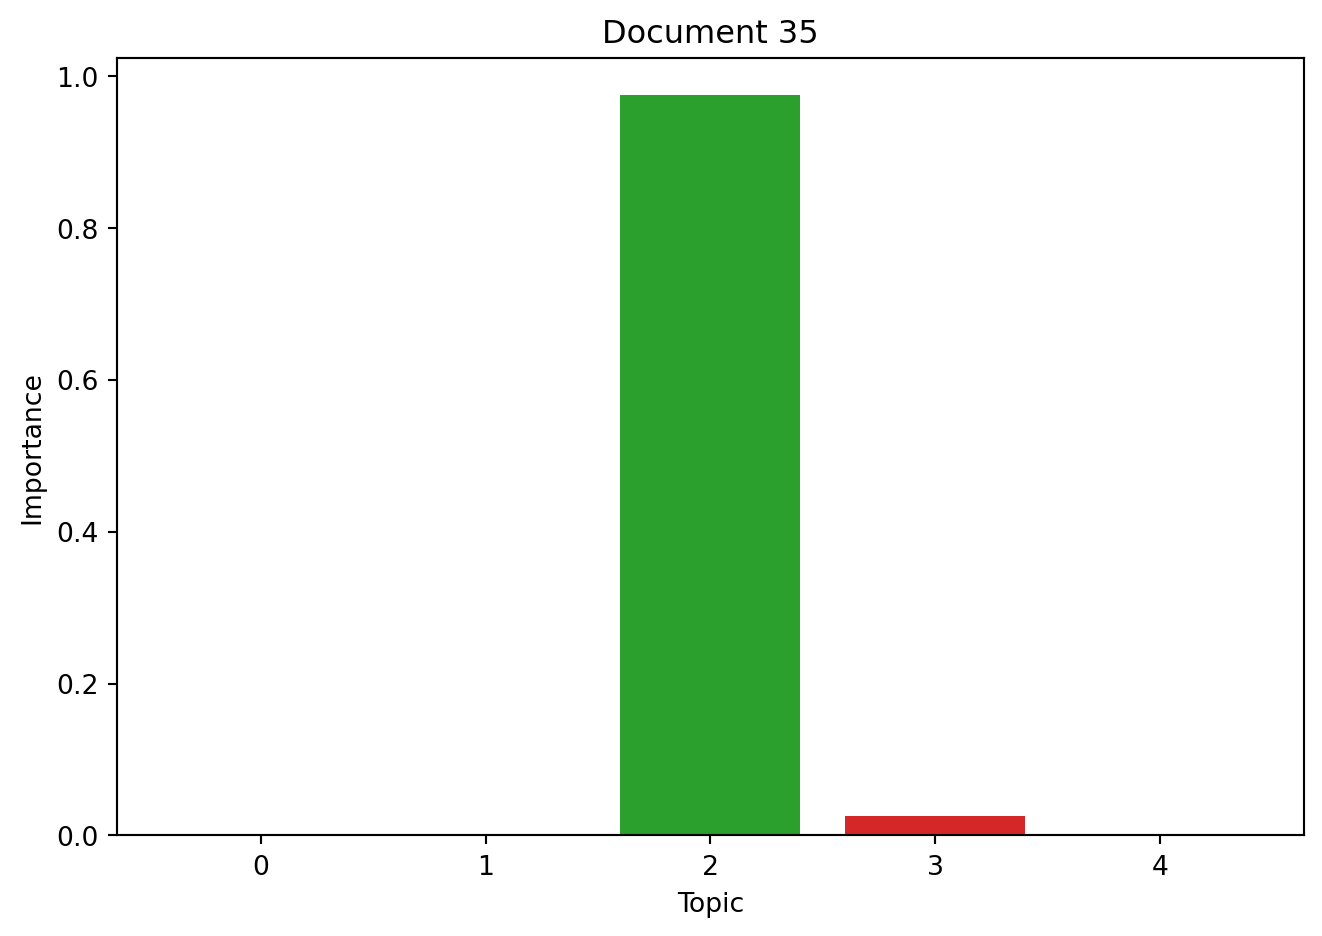

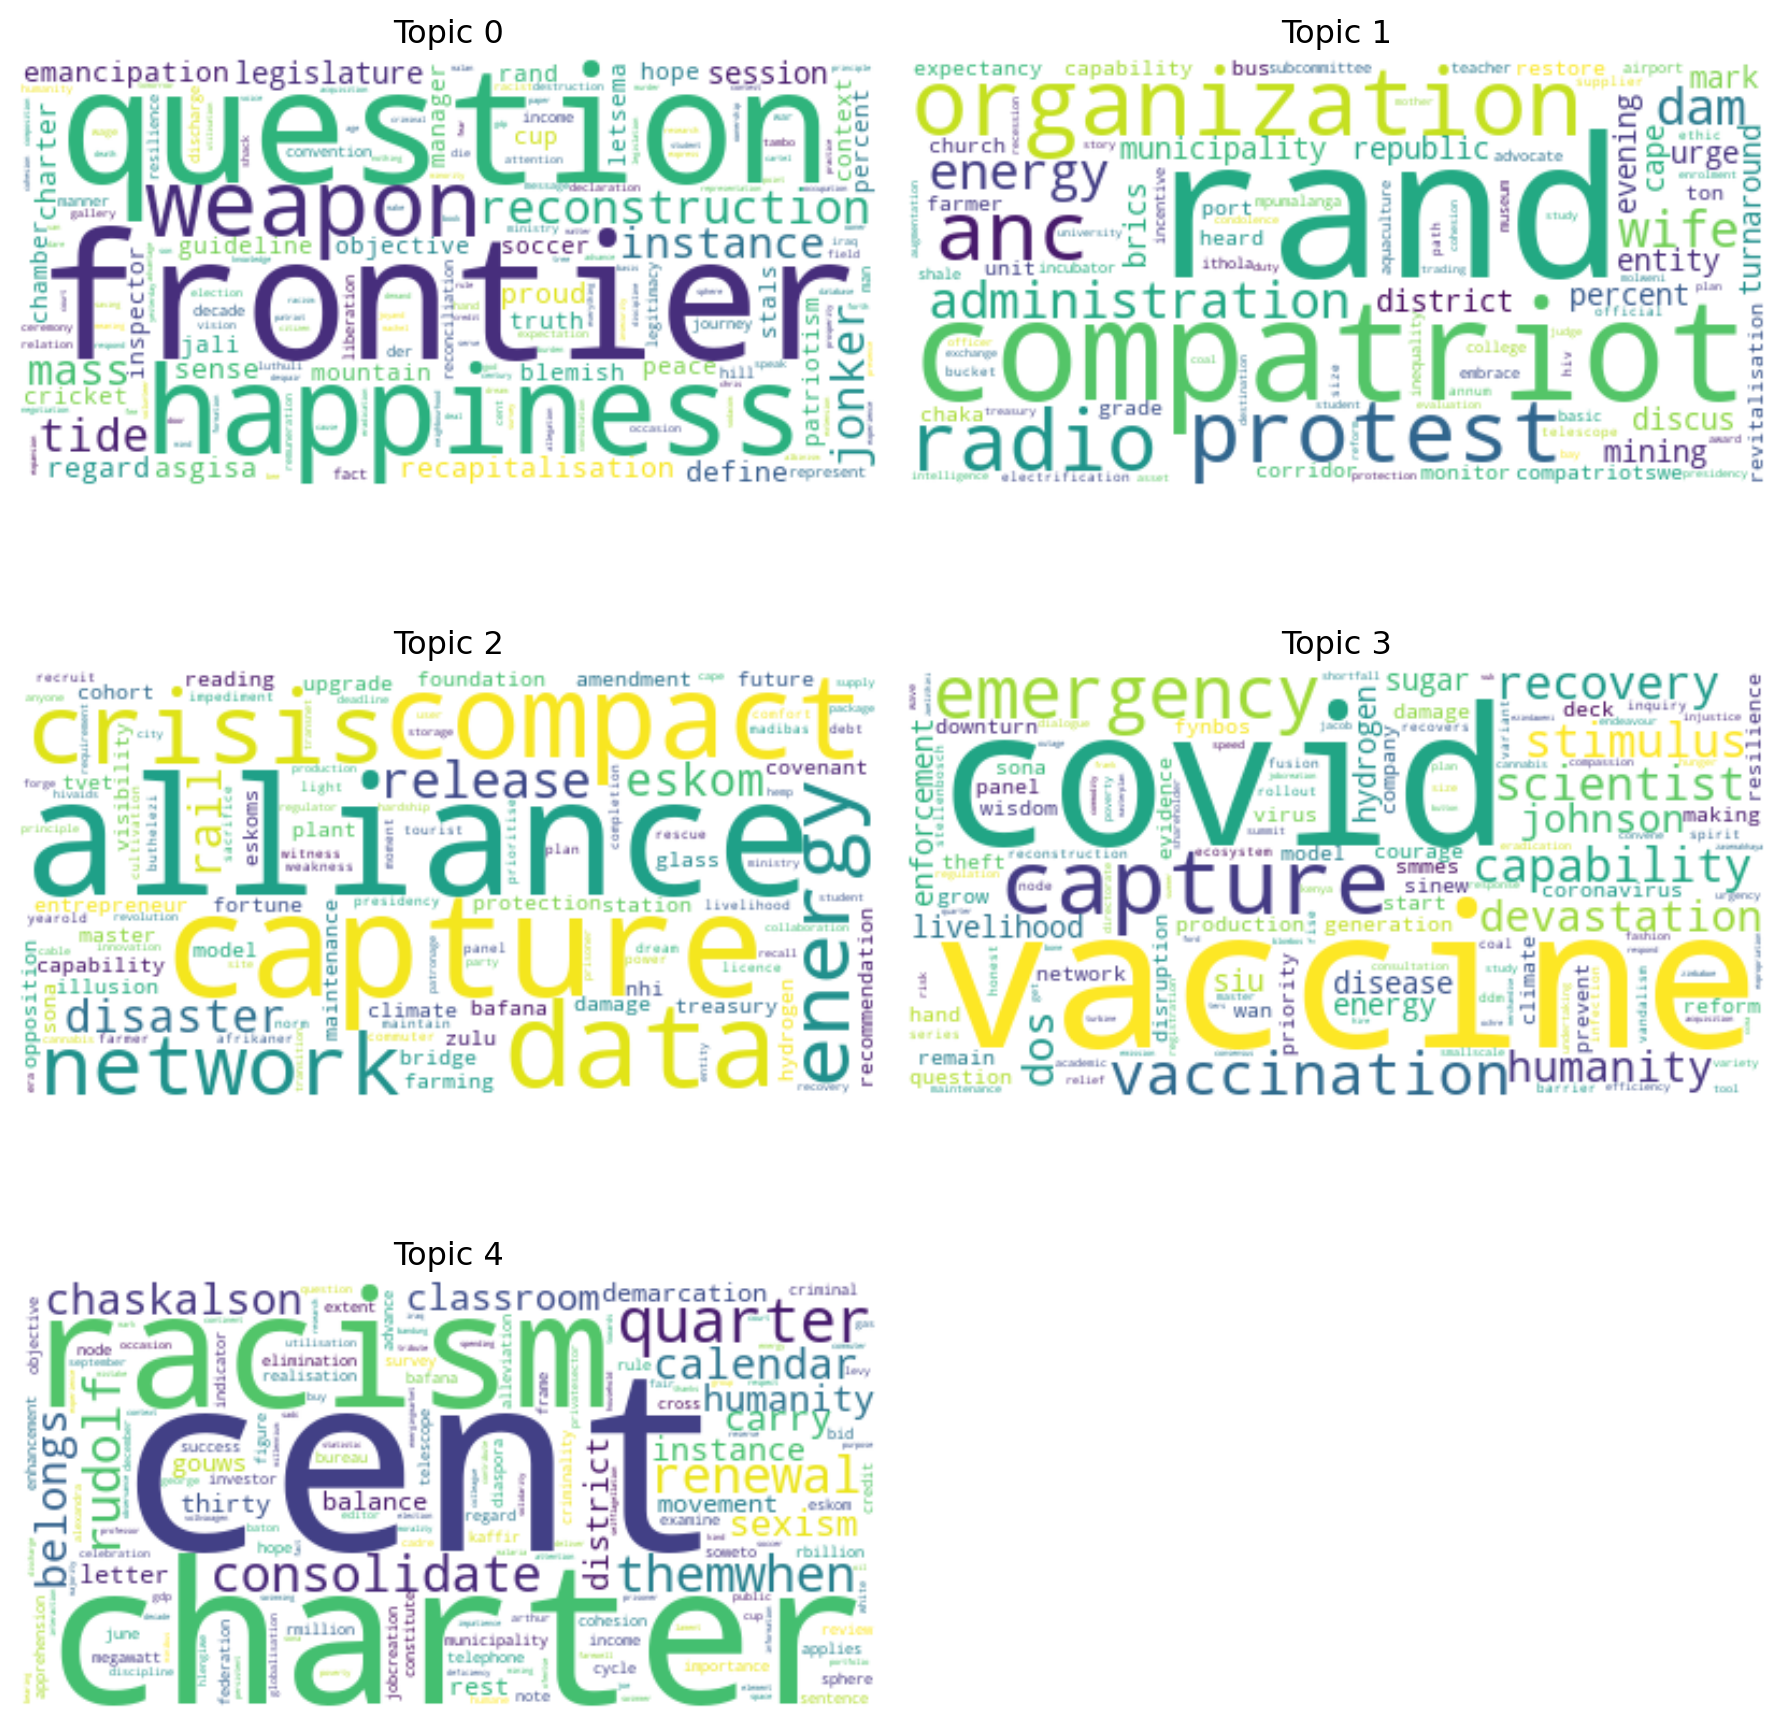

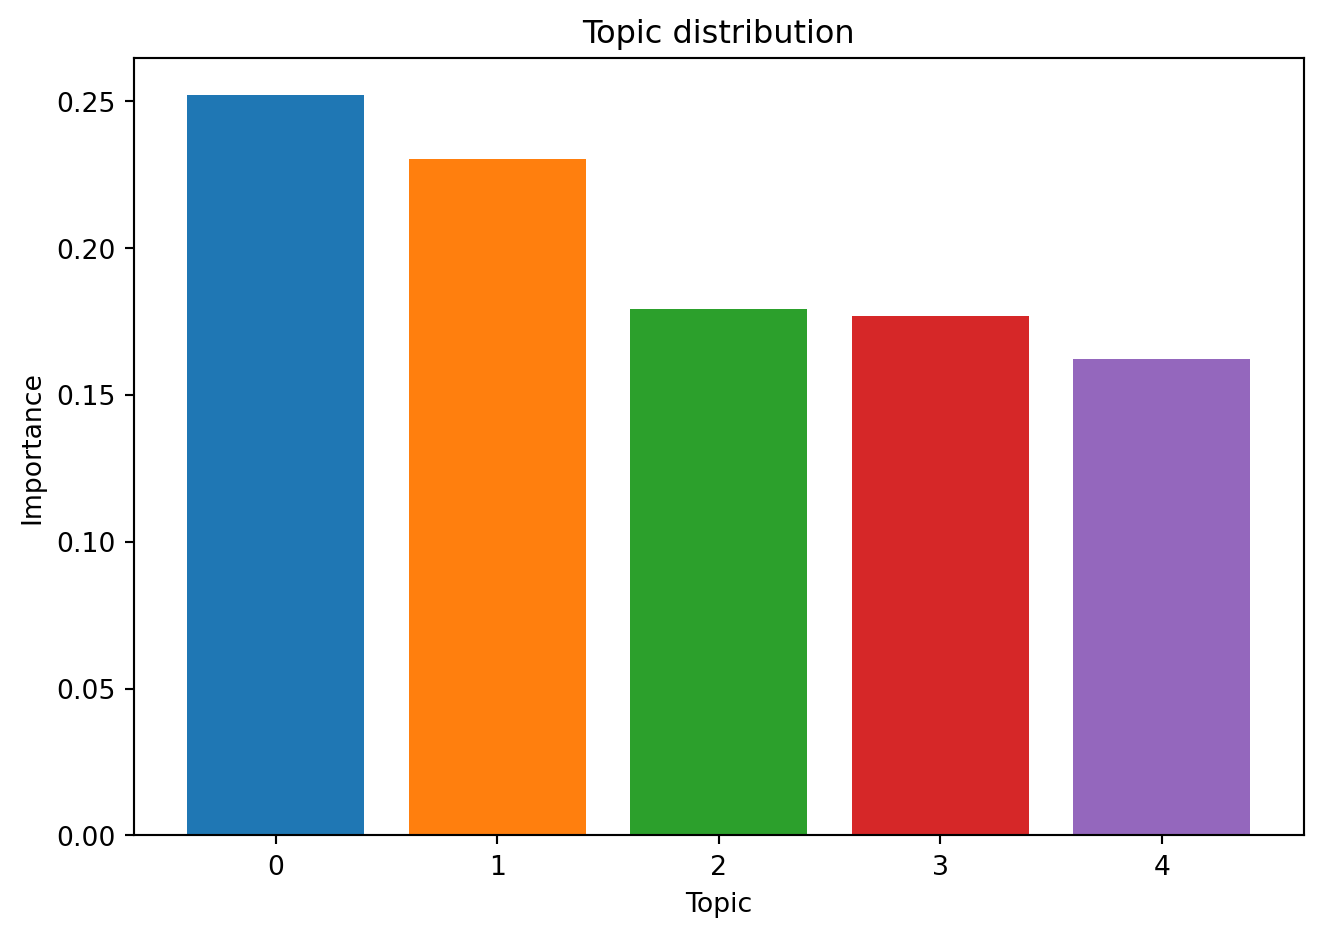

In [22]:
from plsa import Corpus, Pipeline, Visualize
from plsa.pipeline import DEFAULT_PIPELINE
from plsa.algorithms import PLSA

pipeline = Pipeline(*DEFAULT_PIPELINE)
pipeline

corpus = Corpus.from_csv("data/sona_speeches_only.csv", pipeline)
corpus

n_topics = 5

plsa = PLSA(corpus, n_topics, True)
print(plsa)

result = plsa.fit()
print(plsa)

print(result.topic)

visualize = Visualize(result)
visualize

fig, ax = plt.subplots()
_ = visualize.topics_in_doc(35, ax)
fig.tight_layout()


fig = plt.figure(figsize=(9.4, 10))
_ = visualize.wordclouds(fig)

fig, ax = plt.subplots()
_ = visualize.topics(ax)
fig.tight_layout()


# To visualize the word-topic distributions
# Visualize.words(plsa.word_topics, corpus)

In [23]:
import numpy as np
import gensim
from gensim.models import LdaModel
from gensim.models.coherencemodel import CoherenceModel
from gensim import corpora
from gensim.models import TfidfModel
import matplotlib.pyplot as plt
import tqdm

texts = sona_speeches_clean['speech']
sentences = sona_sentences_alltogether['sentence']

# Further process tokens using gensim's simple_preprocess
tokenized_texts = [simple_preprocess(doc, deacc=True) for doc in texts]  # deacc=True removes punctuations
tokenized_sentences = [simple_preprocess(doc, deacc=True) for doc in sentences]  # deacc=True removes punctuations

# Create a Gensim dictionary from the tokenized documents
dictionary = corpora.Dictionary(tokenized_texts)
dictionary.filter_extremes(no_below=3, no_above=0.7)

dict_sentences = corpora.Dictionary(tokenized_sentences)
dict_sentences.filter_extremes(no_below=3, no_above=0.7)

# Create a BOW corpus
bow_corpus = [dictionary.doc2bow(text) for text in tokenized_texts]
bow_corpus_sentences = [dict_sentences.doc2bow(text) for text in tokenized_sentences]

# Create a TF-IDF corpus
tfidf = TfidfModel(bow_corpus)
tfidf_corpus = tfidf[bow_corpus]

tfidf_sentences = TfidfModel(bow_corpus_sentences)
tfidf_corpus_sentences = tfidf_sentences[bow_corpus_sentences]

# Define the function to compute coherence values
def compute_coherence_values(corpus, dictionary, k, a, b):
    lda_model = LdaModel(corpus=corpus,
                         id2word=dictionary,
                         num_topics=k, 
                         random_state=100,
                         eval_every=None,
                         alpha=a,
                         eta=b)
    
    coherence_model_lda = CoherenceModel(model=lda_model, texts=tokenized_texts, dictionary=dictionary, coherence='u_mass')
    
    return coherence_model_lda.get_coherence()

# Define the parameter space for grid search
grid = {}
grid['Validation_Set'] = {}
# Topics range
min_topics = 2
max_topics = 10
step_size = 1
topics_range = range(min_topics, max_topics, step_size)
# Alpha parameter
alpha = list(np.arange(0.1, 1, 0.1))
# Beta parameter
beta = list(np.arange(0.1, 1, 0.2))

# Validation sets
num_of_docs = len(bow_corpus)
corpus_sets = [tfidf_corpus, 
               bow_corpus]
corpus_title = ['TF-IDF Corpus', 'BoW Corpus']
model_results = {'Validation_Set': [],
                 'Topics': [],
                 'Alpha': [],
                 'Beta': [],
                 'Coherence': []
                }
model_results_sentences = {'Validation_Set': [],
                 'Topics': [],
                 'Alpha': [],
                 'Beta': [],
                 'Coherence': []
                }

# Can take a long time to run
# If you want to only test a few models, reduce the number of steps in topics_range
# and/or limit the number of values in alpha and beta lists.
if 1 == 1:
    pbar = tqdm.tqdm(total=(max_topics-min_topics)*len(alpha)*len(beta)*len(corpus_sets))
    
    # iterate through validation corpuses
    for i in range(len(corpus_sets)):
        # iterate through number of topics
        for k in topics_range:
            # iterate through alpha values
            for a in alpha:
                # iterare through beta values
                for b in beta:
                    # get the coherence score for the given parameters
                    cv = compute_coherence_values(corpus=corpus_sets[i], dictionary=dictionary, k=k, a=a, b=b)
                    # Save the model results
                    model_results['Validation_Set'].append(corpus_title[i])
                    model_results['Topics'].append(k)
                    model_results['Alpha'].append(a)
                    model_results['Beta'].append(b)
                    model_results['Coherence'].append(cv)
                    
                    pbar.update(1)
    pbar.close()


# Get the results for the sentences
if 1 == 1:
    pbar = tqdm.tqdm(total=(max_topics-min_topics)*len(alpha)*len(beta)*len(corpus_sets))
    
    # iterate through validation corpuses
    for i in range(len(corpus_sets)):
        # iterate through number of topics
        for k in topics_range:
            # iterate through alpha values
            for a in alpha:
                # iterare through beta values
                for b in beta:
                    # get the coherence score for the given parameters
                    cv = compute_coherence_values(corpus=corpus_sets[i], dictionary=dict_sentences, k=k, a=a, b=b)
                    # Save the model results
                    model_results_sentences['Validation_Set'].append(corpus_title[i])
                    model_results_sentences['Topics'].append(k)
                    model_results_sentences['Alpha'].append(a)
                    model_results_sentences['Beta'].append(b)
                    model_results_sentences['Coherence'].append(cv)
                    
                    pbar.update(1)
    pbar.close()

  0%|          | 0/720 [00:00<?, ?it/s]

  0%|          | 2/720 [00:00<00:54, 13.21it/s]

  1%|          | 4/720 [00:00<00:53, 13.49it/s]

  1%|          | 6/720 [00:00<00:52, 13.62it/s]

  1%|          | 8/720 [00:00<00:52, 13.66it/s]

  1%|▏         | 10/720 [00:00<00:51, 13.69it/s]

  2%|▏         | 12/720 [00:00<00:51, 13.67it/s]

  2%|▏         | 14/720 [00:01<00:51, 13.68it/s]

  2%|▏         | 16/720 [00:01<00:51, 13.69it/s]

  2%|▎         | 18/720 [00:01<00:51, 13.63it/s]

  3%|▎         | 20/720 [00:01<00:51, 13.56it/s]

  3%|▎         | 22/720 [00:01<00:51, 13.63it/s]

  3%|▎         | 24/720 [00:01<00:51, 13.62it/s]

  4%|▎         | 26/720 [00:01<00:50, 13.66it/s]

  4%|▍         | 28/720 [00:02<00:50, 13.71it/s]

  4%|▍         | 30/720 [00:02<00:50, 13.73it/s]

  4%|▍         | 32/720 [00:02<00:49, 13.78it/s]

  5%|▍         | 34/720 [00:02<00:49, 13.80it/s]

  5%|▌         | 36/720 [00:02<00:49, 13.80it/s]

  5%|▌         | 38/720 [00:02<00:49, 13.76it/s]

  6%|▌         | 40/720 [00:02<00:49, 13.65it/s]

  6%|▌         | 42/720 [00:03<00:49, 13.73it/s]

  6%|▌         | 44/720 [00:03<00:49, 13.79it/s]

  6%|▋         | 46/720 [00:03<00:49, 13.60it/s]

  7%|▋         | 48/720 [00:03<00:50, 13.27it/s]

  7%|▋         | 50/720 [00:03<00:51, 13.06it/s]

  7%|▋         | 52/720 [00:03<00:51, 12.91it/s]

  8%|▊         | 54/720 [00:04<00:51, 12.81it/s]

  8%|▊         | 56/720 [00:04<00:52, 12.71it/s]

  8%|▊         | 58/720 [00:04<00:52, 12.67it/s]

  8%|▊         | 60/720 [00:04<00:52, 12.63it/s]

  9%|▊         | 62/720 [00:04<00:52, 12.61it/s]

  9%|▉         | 64/720 [00:04<00:52, 12.54it/s]

  9%|▉         | 66/720 [00:04<00:52, 12.52it/s]

  9%|▉         | 68/720 [00:05<00:52, 12.52it/s]

 10%|▉         | 70/720 [00:05<00:51, 12.52it/s]

 10%|█         | 72/720 [00:05<00:51, 12.51it/s]

 10%|█         | 74/720 [00:05<00:51, 12.50it/s]

 11%|█         | 76/720 [00:05<00:51, 12.52it/s]

 11%|█         | 78/720 [00:05<00:51, 12.52it/s]

 11%|█         | 80/720 [00:06<00:51, 12.48it/s]

 11%|█▏        | 82/720 [00:06<00:51, 12.48it/s]

 12%|█▏        | 84/720 [00:06<00:51, 12.44it/s]

 12%|█▏        | 86/720 [00:06<00:51, 12.39it/s]

 12%|█▏        | 88/720 [00:06<00:50, 12.47it/s]

 12%|█▎        | 90/720 [00:06<00:50, 12.52it/s]

 13%|█▎        | 92/720 [00:07<00:47, 13.13it/s]

 13%|█▎        | 94/720 [00:07<00:46, 13.61it/s]

 13%|█▎        | 96/720 [00:07<00:44, 13.97it/s]

 14%|█▎        | 98/720 [00:07<00:43, 14.21it/s]

 14%|█▍        | 100/720 [00:07<00:43, 14.35it/s]

 14%|█▍        | 102/720 [00:07<00:42, 14.43it/s]

 14%|█▍        | 104/720 [00:07<00:42, 14.48it/s]

 15%|█▍        | 106/720 [00:07<00:42, 14.55it/s]

 15%|█▌        | 108/720 [00:08<00:41, 14.62it/s]

 15%|█▌        | 110/720 [00:08<00:41, 14.67it/s]

 16%|█▌        | 112/720 [00:08<00:41, 14.70it/s]

 16%|█▌        | 114/720 [00:08<00:41, 14.72it/s]

 16%|█▌        | 116/720 [00:08<00:40, 14.74it/s]

 16%|█▋        | 118/720 [00:08<00:40, 14.75it/s]

 17%|█▋        | 120/720 [00:08<00:40, 14.76it/s]

 17%|█▋        | 122/720 [00:09<00:40, 14.75it/s]

 17%|█▋        | 124/720 [00:09<00:40, 14.76it/s]

 18%|█▊        | 126/720 [00:09<00:40, 14.79it/s]

 18%|█▊        | 128/720 [00:09<00:40, 14.80it/s]

 18%|█▊        | 130/720 [00:09<00:39, 14.81it/s]

 18%|█▊        | 132/720 [00:09<00:39, 14.83it/s]

 19%|█▊        | 134/720 [00:09<00:39, 14.83it/s]

 19%|█▉        | 136/720 [00:09<00:39, 14.72it/s]

 19%|█▉        | 138/720 [00:10<00:40, 14.50it/s]

 19%|█▉        | 140/720 [00:10<00:40, 14.35it/s]

 20%|█▉        | 142/720 [00:10<00:40, 14.24it/s]

 20%|██        | 144/720 [00:10<00:40, 14.14it/s]

 20%|██        | 146/720 [00:10<00:40, 14.08it/s]

 21%|██        | 148/720 [00:10<00:40, 14.04it/s]

 21%|██        | 150/720 [00:10<00:40, 14.03it/s]

 21%|██        | 152/720 [00:11<00:40, 14.02it/s]

 21%|██▏       | 154/720 [00:11<00:40, 14.02it/s]

 22%|██▏       | 156/720 [00:11<00:40, 14.01it/s]

 22%|██▏       | 158/720 [00:11<00:40, 13.99it/s]

 22%|██▏       | 160/720 [00:11<00:40, 13.99it/s]

 22%|██▎       | 162/720 [00:11<00:39, 13.98it/s]

 23%|██▎       | 164/720 [00:12<00:39, 13.97it/s]

 23%|██▎       | 166/720 [00:12<00:39, 13.96it/s]

 23%|██▎       | 168/720 [00:12<00:39, 13.97it/s]

 24%|██▎       | 170/720 [00:12<00:39, 13.96it/s]

 24%|██▍       | 172/720 [00:12<00:39, 13.96it/s]

 24%|██▍       | 174/720 [00:12<00:39, 13.98it/s]

 24%|██▍       | 176/720 [00:12<00:38, 14.03it/s]

 25%|██▍       | 178/720 [00:12<00:38, 14.09it/s]

 25%|██▌       | 180/720 [00:13<00:38, 14.14it/s]

 25%|██▌       | 182/720 [00:13<00:38, 13.83it/s]

 26%|██▌       | 184/720 [00:13<00:39, 13.63it/s]

 26%|██▌       | 186/720 [00:13<00:39, 13.47it/s]

 26%|██▌       | 188/720 [00:13<00:39, 13.35it/s]

 26%|██▋       | 190/720 [00:13<00:40, 13.22it/s]

 27%|██▋       | 192/720 [00:14<00:40, 13.18it/s]

 27%|██▋       | 194/720 [00:14<00:39, 13.15it/s]

 27%|██▋       | 196/720 [00:14<00:39, 13.14it/s]

 28%|██▊       | 198/720 [00:14<00:39, 13.10it/s]

 28%|██▊       | 200/720 [00:14<00:39, 13.10it/s]

 28%|██▊       | 202/720 [00:14<00:39, 13.11it/s]

 28%|██▊       | 204/720 [00:14<00:39, 13.11it/s]

 29%|██▊       | 206/720 [00:15<00:39, 13.09it/s]

 29%|██▉       | 208/720 [00:15<00:39, 12.94it/s]

 29%|██▉       | 210/720 [00:15<00:39, 12.96it/s]

 29%|██▉       | 212/720 [00:15<00:39, 13.00it/s]

 30%|██▉       | 214/720 [00:15<00:38, 13.03it/s]

 30%|███       | 216/720 [00:15<00:38, 13.07it/s]

 30%|███       | 218/720 [00:16<00:38, 13.15it/s]

 31%|███       | 220/720 [00:16<00:37, 13.21it/s]

 31%|███       | 222/720 [00:16<00:37, 13.37it/s]

 31%|███       | 224/720 [00:16<00:36, 13.47it/s]

 31%|███▏      | 226/720 [00:16<00:38, 12.72it/s]

 32%|███▏      | 228/720 [00:16<00:49,  9.95it/s]

 32%|███▏      | 230/720 [00:17<00:56,  8.62it/s]

 32%|███▏      | 231/720 [00:17<00:57,  8.44it/s]

 32%|███▏      | 232/720 [00:17<01:00,  8.07it/s]

 32%|███▏      | 233/720 [00:17<01:04,  7.51it/s]

 32%|███▎      | 234/720 [00:17<01:06,  7.34it/s]

 33%|███▎      | 235/720 [00:18<01:09,  6.94it/s]

 33%|███▎      | 236/720 [00:18<01:11,  6.78it/s]

 33%|███▎      | 237/720 [00:18<01:09,  6.93it/s]

 33%|███▎      | 238/720 [00:18<01:08,  7.04it/s]

 33%|███▎      | 239/720 [00:18<01:08,  7.06it/s]

 33%|███▎      | 240/720 [00:18<01:06,  7.19it/s]

 33%|███▎      | 241/720 [00:18<01:07,  7.13it/s]

 34%|███▎      | 242/720 [00:19<01:05,  7.24it/s]

 34%|███▍      | 243/720 [00:19<01:08,  6.98it/s]

 34%|███▍      | 244/720 [00:19<01:11,  6.68it/s]

 34%|███▍      | 245/720 [00:19<01:10,  6.72it/s]

 34%|███▍      | 246/720 [00:19<01:08,  6.91it/s]

 34%|███▍      | 247/720 [00:19<01:08,  6.86it/s]

 34%|███▍      | 248/720 [00:19<01:08,  6.86it/s]

 35%|███▍      | 249/720 [00:20<01:08,  6.86it/s]

 35%|███▍      | 250/720 [00:20<01:08,  6.91it/s]

 35%|███▍      | 251/720 [00:20<01:06,  7.06it/s]

 35%|███▌      | 252/720 [00:20<01:14,  6.26it/s]

 35%|███▌      | 253/720 [00:20<01:11,  6.51it/s]

 35%|███▌      | 254/720 [00:20<01:09,  6.71it/s]

 35%|███▌      | 255/720 [00:20<01:08,  6.79it/s]

 36%|███▌      | 256/720 [00:21<01:08,  6.75it/s]

 36%|███▌      | 257/720 [00:21<01:07,  6.82it/s]

 36%|███▌      | 258/720 [00:21<01:05,  7.10it/s]

 36%|███▌      | 259/720 [00:21<01:06,  6.95it/s]

 36%|███▌      | 260/720 [00:21<01:06,  6.97it/s]

 36%|███▋      | 261/720 [00:21<01:05,  7.04it/s]

 36%|███▋      | 262/720 [00:21<01:04,  7.05it/s]

 37%|███▋      | 263/720 [00:22<01:04,  7.08it/s]

 37%|███▋      | 264/720 [00:22<01:03,  7.19it/s]

 37%|███▋      | 265/720 [00:22<01:02,  7.30it/s]

 37%|███▋      | 266/720 [00:22<00:59,  7.59it/s]

 37%|███▋      | 267/720 [00:22<01:00,  7.54it/s]

 37%|███▋      | 268/720 [00:22<00:58,  7.68it/s]

 37%|███▋      | 269/720 [00:22<00:57,  7.85it/s]

 38%|███▊      | 270/720 [00:22<00:58,  7.66it/s]

 38%|███▊      | 271/720 [00:23<00:59,  7.59it/s]

 38%|███▊      | 272/720 [00:23<01:00,  7.45it/s]

 38%|███▊      | 273/720 [00:23<00:58,  7.70it/s]

 38%|███▊      | 274/720 [00:23<00:57,  7.79it/s]

 38%|███▊      | 275/720 [00:23<00:59,  7.42it/s]

 38%|███▊      | 276/720 [00:23<01:02,  7.11it/s]

 38%|███▊      | 277/720 [00:23<01:02,  7.08it/s]

 39%|███▊      | 278/720 [00:24<01:05,  6.79it/s]

 39%|███▉      | 279/720 [00:24<01:04,  6.82it/s]

 39%|███▉      | 280/720 [00:24<01:01,  7.13it/s]

 39%|███▉      | 281/720 [00:24<01:01,  7.10it/s]

 39%|███▉      | 282/720 [00:24<01:00,  7.20it/s]

 39%|███▉      | 283/720 [00:24<00:59,  7.38it/s]

 39%|███▉      | 284/720 [00:24<00:57,  7.59it/s]

 40%|███▉      | 285/720 [00:25<00:58,  7.43it/s]

 40%|███▉      | 286/720 [00:25<00:58,  7.38it/s]

 40%|███▉      | 287/720 [00:25<00:54,  7.92it/s]

 40%|████      | 288/720 [00:25<00:53,  8.06it/s]

 40%|████      | 289/720 [00:25<00:53,  8.10it/s]

 40%|████      | 290/720 [00:25<00:53,  8.10it/s]

 40%|████      | 291/720 [00:25<00:52,  8.24it/s]

 41%|████      | 292/720 [00:25<00:52,  8.21it/s]

 41%|████      | 293/720 [00:26<00:53,  7.98it/s]

 41%|████      | 294/720 [00:26<00:54,  7.84it/s]

 41%|████      | 295/720 [00:26<00:54,  7.82it/s]

 41%|████      | 296/720 [00:26<00:54,  7.75it/s]

 41%|████▏     | 297/720 [00:26<00:56,  7.53it/s]

 41%|████▏     | 298/720 [00:26<00:54,  7.77it/s]

 42%|████▏     | 299/720 [00:26<00:57,  7.32it/s]

 42%|████▏     | 300/720 [00:26<00:57,  7.32it/s]

 42%|████▏     | 301/720 [00:27<00:55,  7.58it/s]

 42%|████▏     | 302/720 [00:27<00:56,  7.46it/s]

 42%|████▏     | 303/720 [00:27<00:53,  7.79it/s]

 42%|████▏     | 304/720 [00:27<00:52,  7.87it/s]

 42%|████▏     | 305/720 [00:27<00:56,  7.40it/s]

 42%|████▎     | 306/720 [00:27<00:54,  7.58it/s]

 43%|████▎     | 307/720 [00:27<00:53,  7.76it/s]

 43%|████▎     | 308/720 [00:27<00:49,  8.27it/s]

 43%|████▎     | 309/720 [00:28<00:48,  8.40it/s]

 43%|████▎     | 310/720 [00:28<00:51,  7.94it/s]

 43%|████▎     | 311/720 [00:28<00:49,  8.19it/s]

 43%|████▎     | 312/720 [00:28<00:51,  7.85it/s]

 43%|████▎     | 313/720 [00:28<00:51,  7.93it/s]

 44%|████▎     | 314/720 [00:28<00:49,  8.26it/s]

 44%|████▍     | 315/720 [00:28<00:48,  8.29it/s]

 44%|████▍     | 316/720 [00:28<00:53,  7.60it/s]

 44%|████▍     | 317/720 [00:29<01:02,  6.49it/s]

 44%|████▍     | 318/720 [00:29<00:59,  6.76it/s]

 44%|████▍     | 319/720 [00:29<01:01,  6.48it/s]

 44%|████▍     | 320/720 [00:29<01:22,  4.84it/s]

 45%|████▍     | 321/720 [00:29<01:13,  5.41it/s]

 45%|████▍     | 322/720 [00:30<01:14,  5.33it/s]

 45%|████▍     | 323/720 [00:30<01:09,  5.69it/s]

 45%|████▌     | 324/720 [00:30<01:11,  5.57it/s]

 45%|████▌     | 325/720 [00:30<01:08,  5.78it/s]

 45%|████▌     | 326/720 [00:30<01:04,  6.10it/s]

 45%|████▌     | 327/720 [00:30<01:02,  6.29it/s]

 46%|████▌     | 328/720 [00:31<01:07,  5.80it/s]

 46%|████▌     | 329/720 [00:31<01:07,  5.82it/s]

 46%|████▌     | 330/720 [00:31<01:03,  6.17it/s]

 46%|████▌     | 331/720 [00:31<01:02,  6.21it/s]

 46%|████▌     | 332/720 [00:31<01:05,  5.91it/s]

 46%|████▋     | 333/720 [00:32<01:09,  5.61it/s]

 46%|████▋     | 334/720 [00:32<01:07,  5.75it/s]

 47%|████▋     | 335/720 [00:32<01:05,  5.91it/s]

 47%|████▋     | 336/720 [00:32<01:03,  6.02it/s]

 47%|████▋     | 337/720 [00:32<00:59,  6.43it/s]

 47%|████▋     | 338/720 [00:32<01:00,  6.28it/s]

 47%|████▋     | 339/720 [00:32<01:00,  6.30it/s]

 47%|████▋     | 340/720 [00:33<01:01,  6.15it/s]

 47%|████▋     | 341/720 [00:33<00:58,  6.43it/s]

 48%|████▊     | 342/720 [00:33<00:56,  6.72it/s]

 48%|████▊     | 343/720 [00:33<00:54,  6.88it/s]

 48%|████▊     | 344/720 [00:33<00:54,  6.88it/s]

 48%|████▊     | 345/720 [00:33<00:59,  6.32it/s]

 48%|████▊     | 346/720 [00:34<01:00,  6.18it/s]

 48%|████▊     | 347/720 [00:34<00:58,  6.35it/s]

 48%|████▊     | 348/720 [00:34<00:58,  6.37it/s]

 48%|████▊     | 349/720 [00:34<00:59,  6.27it/s]

 49%|████▊     | 350/720 [00:34<00:56,  6.58it/s]

 49%|████▉     | 351/720 [00:34<00:55,  6.61it/s]

 49%|████▉     | 352/720 [00:34<00:53,  6.86it/s]

 49%|████▉     | 353/720 [00:35<00:51,  7.14it/s]

 49%|████▉     | 354/720 [00:35<00:51,  7.09it/s]

 49%|████▉     | 355/720 [00:35<00:48,  7.48it/s]

 49%|████▉     | 356/720 [00:35<00:47,  7.61it/s]

 50%|████▉     | 357/720 [00:35<00:50,  7.18it/s]

 50%|████▉     | 358/720 [00:35<00:49,  7.33it/s]

 50%|████▉     | 359/720 [00:35<00:47,  7.65it/s]

 50%|█████     | 360/720 [00:35<00:46,  7.70it/s]

 50%|█████     | 361/720 [00:36<00:44,  8.12it/s]

 50%|█████     | 363/720 [00:36<00:37,  9.59it/s]

 51%|█████     | 365/720 [00:36<00:30, 11.72it/s]

 51%|█████     | 367/720 [00:36<00:26, 13.48it/s]

 51%|█████▏    | 369/720 [00:36<00:23, 14.87it/s]

 52%|█████▏    | 371/720 [00:36<00:21, 15.94it/s]

 52%|█████▏    | 373/720 [00:36<00:20, 16.73it/s]

 52%|█████▏    | 375/720 [00:36<00:19, 17.31it/s]

 52%|█████▏    | 377/720 [00:36<00:19, 17.61it/s]

 53%|█████▎    | 379/720 [00:37<00:19, 17.76it/s]

 53%|█████▎    | 381/720 [00:37<00:18, 17.97it/s]

 53%|█████▎    | 383/720 [00:37<00:18, 18.04it/s]

 53%|█████▎    | 385/720 [00:37<00:18, 18.13it/s]

 54%|█████▍    | 387/720 [00:37<00:18, 18.19it/s]

 54%|█████▍    | 389/720 [00:37<00:18, 18.25it/s]

 54%|█████▍    | 391/720 [00:37<00:17, 18.40it/s]

 55%|█████▍    | 393/720 [00:37<00:17, 18.49it/s]

 55%|█████▍    | 395/720 [00:37<00:17, 18.54it/s]

 55%|█████▌    | 397/720 [00:38<00:17, 18.59it/s]

 55%|█████▌    | 399/720 [00:38<00:17, 18.63it/s]

 56%|█████▌    | 401/720 [00:38<00:17, 18.68it/s]

 56%|█████▌    | 403/720 [00:38<00:16, 18.72it/s]

 56%|█████▋    | 405/720 [00:38<00:16, 18.71it/s]

 57%|█████▋    | 407/720 [00:38<00:17, 17.90it/s]

 57%|█████▋    | 409/720 [00:38<00:17, 17.44it/s]

 57%|█████▋    | 411/720 [00:38<00:18, 17.15it/s]

 57%|█████▋    | 413/720 [00:38<00:18, 16.96it/s]

 58%|█████▊    | 415/720 [00:39<00:18, 16.82it/s]

 58%|█████▊    | 417/720 [00:39<00:18, 16.72it/s]

 58%|█████▊    | 419/720 [00:39<00:18, 16.66it/s]

 58%|█████▊    | 421/720 [00:39<00:17, 16.64it/s]

 59%|█████▉    | 423/720 [00:39<00:17, 16.60it/s]

 59%|█████▉    | 425/720 [00:39<00:18, 16.26it/s]

 59%|█████▉    | 427/720 [00:39<00:18, 16.22it/s]

 60%|█████▉    | 429/720 [00:39<00:18, 16.06it/s]

 60%|█████▉    | 431/720 [00:40<00:18, 16.02it/s]

 60%|██████    | 433/720 [00:40<00:17, 16.09it/s]

 60%|██████    | 435/720 [00:40<00:17, 16.20it/s]

 61%|██████    | 437/720 [00:40<00:17, 16.27it/s]

 61%|██████    | 439/720 [00:40<00:17, 16.33it/s]

 61%|██████▏   | 441/720 [00:40<00:17, 16.40it/s]

 62%|██████▏   | 443/720 [00:40<00:16, 16.45it/s]

 62%|██████▏   | 445/720 [00:40<00:16, 16.35it/s]

 62%|██████▏   | 447/720 [00:41<00:16, 16.21it/s]

 62%|██████▏   | 449/720 [00:41<00:16, 16.24it/s]

 63%|██████▎   | 451/720 [00:41<00:16, 16.80it/s]

 63%|██████▎   | 454/720 [00:41<00:14, 18.09it/s]

 63%|██████▎   | 457/720 [00:41<00:13, 18.90it/s]

 64%|██████▍   | 460/720 [00:41<00:13, 19.34it/s]

 64%|██████▍   | 463/720 [00:41<00:13, 19.76it/s]

 65%|██████▍   | 466/720 [00:42<00:12, 20.02it/s]

 65%|██████▌   | 469/720 [00:42<00:12, 20.20it/s]

 66%|██████▌   | 472/720 [00:42<00:12, 20.34it/s]

 66%|██████▌   | 475/720 [00:42<00:11, 20.47it/s]

 66%|██████▋   | 478/720 [00:42<00:11, 20.52it/s]

 67%|██████▋   | 481/720 [00:42<00:11, 20.57it/s]

 67%|██████▋   | 484/720 [00:42<00:11, 20.59it/s]

 68%|██████▊   | 487/720 [00:43<00:11, 20.54it/s]

 68%|██████▊   | 490/720 [00:43<00:11, 20.54it/s]

 68%|██████▊   | 493/720 [00:43<00:11, 20.58it/s]

 69%|██████▉   | 496/720 [00:43<00:10, 20.45it/s]

 69%|██████▉   | 499/720 [00:43<00:11, 19.98it/s]

 70%|██████▉   | 502/720 [00:43<00:11, 19.70it/s]

 70%|███████   | 504/720 [00:43<00:11, 19.54it/s]

 70%|███████   | 506/720 [00:44<00:11, 19.11it/s]

 71%|███████   | 508/720 [00:44<00:11, 18.69it/s]

 71%|███████   | 510/720 [00:44<00:11, 18.71it/s]

 71%|███████   | 512/720 [00:44<00:11, 18.78it/s]

 71%|███████▏  | 514/720 [00:44<00:10, 18.84it/s]

 72%|███████▏  | 516/720 [00:44<00:10, 18.87it/s]

 72%|███████▏  | 518/720 [00:44<00:10, 18.90it/s]

 72%|███████▏  | 520/720 [00:44<00:10, 18.95it/s]

 72%|███████▎  | 522/720 [00:44<00:10, 18.98it/s]

 73%|███████▎  | 524/720 [00:44<00:10, 19.01it/s]

 73%|███████▎  | 526/720 [00:45<00:10, 19.02it/s]

 73%|███████▎  | 528/720 [00:45<00:10, 18.95it/s]

 74%|███████▎  | 530/720 [00:45<00:10, 18.96it/s]

 74%|███████▍  | 532/720 [00:45<00:09, 18.98it/s]

 74%|███████▍  | 534/720 [00:45<00:09, 18.99it/s]

 74%|███████▍  | 536/720 [00:45<00:09, 19.00it/s]

 75%|███████▍  | 538/720 [00:45<00:09, 19.00it/s]

 75%|███████▌  | 540/720 [00:45<00:09, 19.03it/s]

 75%|███████▌  | 542/720 [00:45<00:09, 18.50it/s]

 76%|███████▌  | 544/720 [00:46<00:09, 18.02it/s]

 76%|███████▌  | 546/720 [00:46<00:09, 17.69it/s]

 76%|███████▌  | 548/720 [00:46<00:09, 17.53it/s]

 76%|███████▋  | 550/720 [00:46<00:09, 17.45it/s]

 77%|███████▋  | 552/720 [00:46<00:09, 17.30it/s]

 77%|███████▋  | 554/720 [00:46<00:09, 17.31it/s]

 77%|███████▋  | 556/720 [00:46<00:09, 17.34it/s]

 78%|███████▊  | 558/720 [00:46<00:09, 17.27it/s]

 78%|███████▊  | 560/720 [00:46<00:09, 17.11it/s]

 78%|███████▊  | 562/720 [00:47<00:09, 17.14it/s]

 78%|███████▊  | 564/720 [00:47<00:09, 17.20it/s]

 79%|███████▊  | 566/720 [00:47<00:08, 17.15it/s]

 79%|███████▉  | 568/720 [00:47<00:08, 17.12it/s]

 79%|███████▉  | 570/720 [00:47<00:08, 17.22it/s]

 79%|███████▉  | 572/720 [00:47<00:08, 17.22it/s]

 80%|███████▉  | 574/720 [00:47<00:08, 17.19it/s]

 80%|████████  | 576/720 [00:47<00:08, 17.27it/s]

 80%|████████  | 578/720 [00:48<00:08, 17.32it/s]

 81%|████████  | 580/720 [00:48<00:08, 17.36it/s]

 81%|████████  | 582/720 [00:48<00:07, 17.39it/s]

 81%|████████  | 584/720 [00:48<00:07, 17.35it/s]

 81%|████████▏ | 586/720 [00:48<00:08, 16.13it/s]

 82%|████████▏ | 588/720 [00:48<00:10, 13.03it/s]

 82%|████████▏ | 590/720 [00:48<00:11, 11.45it/s]

 82%|████████▏ | 592/720 [00:49<00:11, 11.03it/s]

 82%|████████▎ | 594/720 [00:49<00:13,  9.22it/s]

 83%|████████▎ | 596/720 [00:49<00:13,  9.48it/s]

 83%|████████▎ | 598/720 [00:49<00:12,  9.55it/s]

 83%|████████▎ | 600/720 [00:50<00:12,  9.54it/s]

 83%|████████▎ | 601/720 [00:50<00:12,  9.24it/s]

 84%|████████▎ | 602/720 [00:50<00:12,  9.23it/s]

 84%|████████▍ | 603/720 [00:50<00:12,  9.00it/s]

 84%|████████▍ | 604/720 [00:50<00:13,  8.77it/s]

 84%|████████▍ | 605/720 [00:50<00:13,  8.75it/s]

 84%|████████▍ | 606/720 [00:50<00:13,  8.69it/s]

 84%|████████▍ | 607/720 [00:50<00:13,  8.53it/s]

 84%|████████▍ | 608/720 [00:51<00:12,  8.67it/s]

 85%|████████▍ | 609/720 [00:51<00:12,  8.61it/s]

 85%|████████▍ | 610/720 [00:51<00:12,  8.94it/s]

 85%|████████▍ | 611/720 [00:51<00:12,  8.94it/s]

 85%|████████▌ | 612/720 [00:51<00:13,  8.08it/s]

 85%|████████▌ | 613/720 [00:51<00:12,  8.32it/s]

 85%|████████▌ | 614/720 [00:51<00:12,  8.50it/s]

 85%|████████▌ | 615/720 [00:51<00:11,  8.77it/s]

 86%|████████▌ | 616/720 [00:51<00:11,  8.79it/s]

 86%|████████▌ | 617/720 [00:52<00:11,  8.73it/s]

 86%|████████▌ | 618/720 [00:52<00:11,  8.80it/s]

 86%|████████▌ | 619/720 [00:52<00:11,  9.01it/s]

 86%|████████▌ | 620/720 [00:52<00:11,  8.44it/s]

 86%|████████▋ | 622/720 [00:52<00:10,  9.28it/s]

 87%|████████▋ | 623/720 [00:52<00:10,  9.29it/s]

 87%|████████▋ | 624/720 [00:52<00:10,  9.16it/s]

 87%|████████▋ | 625/720 [00:52<00:10,  8.99it/s]

 87%|████████▋ | 626/720 [00:53<00:10,  9.11it/s]

 87%|████████▋ | 628/720 [00:53<00:09,  9.56it/s]

 87%|████████▋ | 629/720 [00:53<00:09,  9.25it/s]

 88%|████████▊ | 630/720 [00:53<00:09,  9.16it/s]

 88%|████████▊ | 631/720 [00:53<00:09,  9.30it/s]

 88%|████████▊ | 633/720 [00:53<00:08, 10.02it/s]

 88%|████████▊ | 635/720 [00:53<00:08, 10.29it/s]

 88%|████████▊ | 637/720 [00:54<00:08,  9.57it/s]

 89%|████████▉ | 639/720 [00:54<00:07, 10.25it/s]

 89%|████████▉ | 641/720 [00:54<00:07, 10.58it/s]

 89%|████████▉ | 643/720 [00:54<00:07, 10.34it/s]

 90%|████████▉ | 645/720 [00:54<00:07, 10.51it/s]

 90%|████████▉ | 647/720 [00:55<00:06, 10.58it/s]

 90%|█████████ | 649/720 [00:55<00:06, 11.01it/s]

 90%|█████████ | 651/720 [00:55<00:06, 10.99it/s]

 91%|█████████ | 653/720 [00:55<00:06, 11.04it/s]

 91%|█████████ | 655/720 [00:55<00:06, 10.82it/s]

 91%|█████████▏| 657/720 [00:56<00:05, 10.88it/s]

 92%|█████████▏| 659/720 [00:56<00:05, 10.98it/s]

 92%|█████████▏| 661/720 [00:56<00:05, 10.46it/s]

 92%|█████████▏| 663/720 [00:56<00:05, 10.53it/s]

 92%|█████████▏| 665/720 [00:56<00:04, 11.02it/s]

 93%|█████████▎| 667/720 [00:56<00:04, 11.13it/s]

 93%|█████████▎| 669/720 [00:57<00:04, 11.06it/s]

 93%|█████████▎| 671/720 [00:57<00:04, 11.14it/s]

 93%|█████████▎| 673/720 [00:57<00:04, 11.15it/s]

 94%|█████████▍| 675/720 [00:57<00:04, 10.95it/s]

 94%|█████████▍| 677/720 [00:57<00:03, 10.77it/s]

 94%|█████████▍| 679/720 [00:58<00:03, 10.49it/s]

 95%|█████████▍| 681/720 [00:58<00:03, 10.38it/s]

 95%|█████████▍| 683/720 [00:58<00:03, 10.22it/s]

 95%|█████████▌| 685/720 [00:58<00:03, 10.09it/s]

 95%|█████████▌| 687/720 [00:58<00:03, 10.13it/s]

 96%|█████████▌| 689/720 [00:59<00:03,  9.90it/s]

 96%|█████████▌| 690/720 [00:59<00:03,  9.78it/s]

 96%|█████████▌| 692/720 [00:59<00:02, 10.14it/s]

 96%|█████████▋| 694/720 [00:59<00:02, 10.38it/s]

 97%|█████████▋| 696/720 [00:59<00:02, 10.28it/s]

 97%|█████████▋| 698/720 [00:59<00:02, 10.73it/s]

 97%|█████████▋| 700/720 [01:00<00:01, 10.67it/s]

 98%|█████████▊| 702/720 [01:00<00:01, 10.15it/s]

 98%|█████████▊| 704/720 [01:00<00:01, 10.36it/s]

 98%|█████████▊| 706/720 [01:00<00:01, 10.51it/s]

 98%|█████████▊| 708/720 [01:00<00:01, 10.56it/s]

 99%|█████████▊| 710/720 [01:01<00:00, 10.12it/s]

 99%|█████████▉| 712/720 [01:01<00:00, 10.14it/s]

 99%|█████████▉| 714/720 [01:01<00:00, 10.19it/s]

 99%|█████████▉| 716/720 [01:01<00:00, 10.41it/s]

100%|█████████▉| 718/720 [01:01<00:00, 10.52it/s]

100%|██████████| 720/720 [01:02<00:00, 10.01it/s]

100%|██████████| 720/720 [01:02<00:00, 11.60it/s]

  0%|          | 0/720 [00:00<?, ?it/s]

  0%|          | 1/720 [00:00<01:38,  7.27it/s]

  0%|          | 2/720 [00:00<01:29,  8.02it/s]

  1%|          | 4/720 [00:00<01:07, 10.61it/s]

  1%|          | 6/720 [00:00<01:01, 11.66it/s]

  1%|          | 8/720 [00:00<00:58, 12.17it/s]

  1%|▏         | 10/720 [00:00<00:56, 12.48it/s]

  2%|▏         | 12/720 [00:01<00:55, 12.66it/s]

  2%|▏         | 14/720 [00:01<00:55, 12.79it/s]

  2%|▏         | 16/720 [00:01<00:54, 12.86it/s]

  2%|▎         | 18/720 [00:01<00:54, 12.91it/s]

  3%|▎         | 20/720 [00:01<00:54, 12.90it/s]

  3%|▎         | 22/720 [00:01<00:54, 12.83it/s]

  3%|▎         | 24/720 [00:01<00:54, 12.81it/s]

  4%|▎         | 26/720 [00:02<00:53, 12.89it/s]

  4%|▍         | 28/720 [00:02<00:53, 12.97it/s]

  4%|▍         | 30/720 [00:02<00:52, 13.02it/s]

  4%|▍         | 32/720 [00:02<00:52, 13.09it/s]

  5%|▍         | 34/720 [00:02<00:52, 13.12it/s]

  5%|▌         | 36/720 [00:02<00:52, 13.13it/s]

  5%|▌         | 38/720 [00:03<00:52, 13.01it/s]

  6%|▌         | 40/720 [00:03<00:52, 12.96it/s]

  6%|▌         | 42/720 [00:03<00:52, 12.90it/s]

  6%|▌         | 44/720 [00:03<00:52, 12.84it/s]

  6%|▋         | 46/720 [00:03<00:53, 12.63it/s]

  7%|▋         | 48/720 [00:03<00:54, 12.35it/s]

  7%|▋         | 50/720 [00:03<00:54, 12.21it/s]

  7%|▋         | 52/720 [00:04<00:55, 12.11it/s]

  8%|▊         | 54/720 [00:04<00:55, 11.99it/s]

  8%|▊         | 56/720 [00:04<00:55, 11.93it/s]

  8%|▊         | 58/720 [00:04<00:55, 11.89it/s]

  8%|▊         | 60/720 [00:04<00:55, 11.81it/s]

  9%|▊         | 62/720 [00:05<00:55, 11.82it/s]

  9%|▉         | 64/720 [00:05<00:55, 11.83it/s]

  9%|▉         | 66/720 [00:05<00:55, 11.85it/s]

  9%|▉         | 68/720 [00:05<00:54, 11.87it/s]

 10%|▉         | 70/720 [00:05<00:54, 11.88it/s]

 10%|█         | 72/720 [00:05<00:54, 11.90it/s]

 10%|█         | 74/720 [00:06<00:54, 11.92it/s]

 11%|█         | 76/720 [00:06<00:54, 11.92it/s]

 11%|█         | 78/720 [00:06<00:53, 11.90it/s]

 11%|█         | 80/720 [00:06<00:53, 11.89it/s]

 11%|█▏        | 82/720 [00:06<00:53, 11.90it/s]

 12%|█▏        | 84/720 [00:06<00:53, 11.90it/s]

 12%|█▏        | 86/720 [00:07<00:53, 11.92it/s]

 12%|█▏        | 88/720 [00:07<00:52, 11.94it/s]

 12%|█▎        | 90/720 [00:07<00:52, 11.95it/s]

 13%|█▎        | 92/720 [00:07<00:50, 12.46it/s]

 13%|█▎        | 94/720 [00:07<00:48, 12.84it/s]

 13%|█▎        | 96/720 [00:07<00:47, 13.14it/s]

 14%|█▎        | 98/720 [00:07<00:46, 13.36it/s]

 14%|█▍        | 100/720 [00:08<00:45, 13.51it/s]

 14%|█▍        | 102/720 [00:08<00:45, 13.61it/s]

 14%|█▍        | 104/720 [00:08<00:45, 13.67it/s]

 15%|█▍        | 106/720 [00:08<00:44, 13.73it/s]

 15%|█▌        | 108/720 [00:08<00:44, 13.77it/s]

 15%|█▌        | 110/720 [00:08<00:44, 13.80it/s]

 16%|█▌        | 112/720 [00:08<00:43, 13.82it/s]

 16%|█▌        | 114/720 [00:09<00:43, 13.83it/s]

 16%|█▌        | 116/720 [00:09<00:43, 13.84it/s]

 16%|█▋        | 118/720 [00:09<00:43, 13.85it/s]

 17%|█▋        | 120/720 [00:09<00:43, 13.87it/s]

 17%|█▋        | 122/720 [00:09<00:43, 13.86it/s]

 17%|█▋        | 124/720 [00:09<00:42, 13.87it/s]

 18%|█▊        | 126/720 [00:09<00:42, 13.89it/s]

 18%|█▊        | 128/720 [00:10<00:42, 13.90it/s]

 18%|█▊        | 130/720 [00:10<00:42, 13.92it/s]

 18%|█▊        | 132/720 [00:10<00:42, 13.94it/s]

 19%|█▊        | 134/720 [00:10<00:42, 13.94it/s]

 19%|█▉        | 136/720 [00:10<00:42, 13.83it/s]

 19%|█▉        | 138/720 [00:10<00:42, 13.64it/s]

 19%|█▉        | 140/720 [00:10<00:42, 13.49it/s]

 20%|█▉        | 142/720 [00:11<00:43, 13.38it/s]

 20%|██        | 144/720 [00:11<00:43, 13.30it/s]

 20%|██        | 146/720 [00:11<00:43, 13.25it/s]

 21%|██        | 148/720 [00:11<00:43, 13.21it/s]

 21%|██        | 150/720 [00:11<00:43, 13.19it/s]

 21%|██        | 152/720 [00:11<00:43, 13.17it/s]

 21%|██▏       | 154/720 [00:12<00:42, 13.16it/s]

 22%|██▏       | 156/720 [00:12<00:42, 13.15it/s]

 22%|██▏       | 158/720 [00:12<00:42, 13.15it/s]

 22%|██▏       | 160/720 [00:12<00:42, 13.15it/s]

 22%|██▎       | 162/720 [00:12<00:42, 13.15it/s]

 23%|██▎       | 164/720 [00:12<00:42, 13.15it/s]

 23%|██▎       | 166/720 [00:12<00:42, 13.15it/s]

 23%|██▎       | 168/720 [00:13<00:41, 13.15it/s]

 24%|██▎       | 170/720 [00:13<00:41, 13.16it/s]

 24%|██▍       | 172/720 [00:13<00:41, 13.17it/s]

 24%|██▍       | 174/720 [00:13<00:41, 13.16it/s]

 24%|██▍       | 176/720 [00:13<00:41, 13.18it/s]

 25%|██▍       | 178/720 [00:13<00:41, 13.20it/s]

 25%|██▌       | 180/720 [00:14<00:40, 13.24it/s]

 25%|██▌       | 182/720 [00:14<00:41, 12.99it/s]

 26%|██▌       | 184/720 [00:14<00:41, 12.81it/s]

 26%|██▌       | 186/720 [00:14<00:42, 12.68it/s]

 26%|██▌       | 188/720 [00:14<00:42, 12.56it/s]

 26%|██▋       | 190/720 [00:14<00:42, 12.50it/s]

 27%|██▋       | 192/720 [00:14<00:42, 12.45it/s]

 27%|██▋       | 194/720 [00:15<00:42, 12.41it/s]

 27%|██▋       | 196/720 [00:15<00:42, 12.39it/s]

 28%|██▊       | 198/720 [00:15<00:42, 12.37it/s]

 28%|██▊       | 200/720 [00:15<00:42, 12.36it/s]

 28%|██▊       | 202/720 [00:15<00:41, 12.36it/s]

 28%|██▊       | 204/720 [00:15<00:41, 12.35it/s]

 29%|██▊       | 206/720 [00:16<00:41, 12.36it/s]

 29%|██▉       | 208/720 [00:16<00:41, 12.36it/s]

 29%|██▉       | 210/720 [00:16<00:41, 12.36it/s]

 29%|██▉       | 212/720 [00:16<00:41, 12.38it/s]

 30%|██▉       | 214/720 [00:16<00:40, 12.38it/s]

 30%|███       | 216/720 [00:16<00:40, 12.40it/s]

 30%|███       | 218/720 [00:17<00:40, 12.44it/s]

 31%|███       | 220/720 [00:17<00:40, 12.48it/s]

 31%|███       | 222/720 [00:17<00:39, 12.62it/s]

 31%|███       | 224/720 [00:17<00:38, 12.72it/s]

 31%|███▏      | 226/720 [00:17<00:40, 12.24it/s]

 32%|███▏      | 228/720 [00:18<00:48, 10.07it/s]

 32%|███▏      | 230/720 [00:18<00:54,  9.02it/s]

 32%|███▏      | 231/720 [00:18<00:58,  8.30it/s]

 32%|███▏      | 232/720 [00:18<01:01,  7.91it/s]

 32%|███▏      | 233/720 [00:18<01:06,  7.29it/s]

 32%|███▎      | 234/720 [00:18<01:09,  7.03it/s]

 33%|███▎      | 235/720 [00:19<01:08,  7.06it/s]

 33%|███▎      | 236/720 [00:19<01:10,  6.85it/s]

 33%|███▎      | 237/720 [00:19<01:13,  6.57it/s]

 33%|███▎      | 238/720 [00:19<01:12,  6.60it/s]

 33%|███▎      | 239/720 [00:19<01:14,  6.44it/s]

 33%|███▎      | 240/720 [00:19<01:12,  6.59it/s]

 33%|███▎      | 241/720 [00:20<01:11,  6.71it/s]

 34%|███▎      | 242/720 [00:20<01:11,  6.71it/s]

 34%|███▍      | 243/720 [00:20<01:14,  6.42it/s]

 34%|███▍      | 244/720 [00:20<01:13,  6.47it/s]

 34%|███▍      | 245/720 [00:20<01:06,  7.15it/s]

 34%|███▍      | 246/720 [00:20<01:06,  7.18it/s]

 34%|███▍      | 247/720 [00:20<01:06,  7.14it/s]

 34%|███▍      | 248/720 [00:21<01:08,  6.92it/s]

 35%|███▍      | 249/720 [00:21<01:22,  5.73it/s]

 35%|███▍      | 250/720 [00:21<01:16,  6.15it/s]

 35%|███▍      | 251/720 [00:21<01:13,  6.34it/s]

 35%|███▌      | 252/720 [00:21<01:17,  6.03it/s]

 35%|███▌      | 253/720 [00:21<01:16,  6.07it/s]

 35%|███▌      | 254/720 [00:22<01:13,  6.38it/s]

 35%|███▌      | 255/720 [00:22<01:11,  6.54it/s]

 36%|███▌      | 256/720 [00:22<01:09,  6.63it/s]

 36%|███▌      | 257/720 [00:22<01:10,  6.59it/s]

 36%|███▌      | 258/720 [00:22<01:08,  6.76it/s]

 36%|███▌      | 259/720 [00:22<01:09,  6.61it/s]

 36%|███▌      | 260/720 [00:22<01:08,  6.74it/s]

 36%|███▋      | 261/720 [00:23<01:05,  7.02it/s]

 36%|███▋      | 262/720 [00:23<01:03,  7.18it/s]

 37%|███▋      | 263/720 [00:23<01:03,  7.15it/s]

 37%|███▋      | 264/720 [00:23<01:02,  7.28it/s]

 37%|███▋      | 265/720 [00:23<01:02,  7.31it/s]

 37%|███▋      | 266/720 [00:23<01:03,  7.11it/s]

 37%|███▋      | 267/720 [00:23<01:01,  7.32it/s]

 37%|███▋      | 268/720 [00:23<01:01,  7.34it/s]

 37%|███▋      | 269/720 [00:24<01:01,  7.31it/s]

 38%|███▊      | 270/720 [00:24<01:01,  7.32it/s]

 38%|███▊      | 271/720 [00:24<01:01,  7.31it/s]

 38%|███▊      | 272/720 [00:24<01:02,  7.19it/s]

 38%|███▊      | 273/720 [00:24<01:00,  7.44it/s]

 38%|███▊      | 274/720 [00:24<00:58,  7.60it/s]

 38%|███▊      | 275/720 [00:24<00:58,  7.63it/s]

 38%|███▊      | 276/720 [00:25<00:59,  7.42it/s]

 38%|███▊      | 277/720 [00:25<01:01,  7.19it/s]

 39%|███▊      | 278/720 [00:25<01:00,  7.32it/s]

 39%|███▉      | 279/720 [00:25<01:00,  7.34it/s]

 39%|███▉      | 280/720 [00:25<00:58,  7.50it/s]

 39%|███▉      | 281/720 [00:25<00:59,  7.36it/s]

 39%|███▉      | 282/720 [00:25<01:00,  7.26it/s]

 39%|███▉      | 283/720 [00:26<01:11,  6.15it/s]

 39%|███▉      | 284/720 [00:26<01:07,  6.46it/s]

 40%|███▉      | 285/720 [00:26<01:08,  6.37it/s]

 40%|███▉      | 286/720 [00:26<01:09,  6.26it/s]

 40%|███▉      | 287/720 [00:26<01:06,  6.47it/s]

 40%|████      | 288/720 [00:26<01:04,  6.67it/s]

 40%|████      | 289/720 [00:27<01:08,  6.32it/s]

 40%|████      | 290/720 [00:27<01:08,  6.26it/s]

 40%|████      | 291/720 [00:27<01:06,  6.47it/s]

 41%|████      | 292/720 [00:27<01:04,  6.68it/s]

 41%|████      | 293/720 [00:27<01:02,  6.83it/s]

 41%|████      | 294/720 [00:27<01:02,  6.80it/s]

 41%|████      | 295/720 [00:27<01:01,  6.93it/s]

 41%|████      | 296/720 [00:28<01:07,  6.29it/s]

 41%|████▏     | 297/720 [00:28<01:07,  6.30it/s]

 41%|████▏     | 298/720 [00:28<01:07,  6.30it/s]

 42%|████▏     | 299/720 [00:28<01:11,  5.93it/s]

 42%|████▏     | 300/720 [00:28<01:05,  6.42it/s]

 42%|████▏     | 301/720 [00:28<01:03,  6.60it/s]

 42%|████▏     | 302/720 [00:29<01:01,  6.75it/s]

 42%|████▏     | 303/720 [00:29<01:00,  6.90it/s]

 42%|████▏     | 304/720 [00:29<00:58,  7.09it/s]

 42%|████▏     | 305/720 [00:29<01:01,  6.77it/s]

 42%|████▎     | 306/720 [00:29<01:02,  6.63it/s]

 43%|████▎     | 307/720 [00:29<00:58,  7.01it/s]

 43%|████▎     | 308/720 [00:29<00:58,  7.07it/s]

 43%|████▎     | 309/720 [00:29<00:56,  7.32it/s]

 43%|████▎     | 310/720 [00:30<00:54,  7.49it/s]

 43%|████▎     | 311/720 [00:30<00:58,  7.00it/s]

 43%|████▎     | 312/720 [00:30<01:02,  6.54it/s]

 43%|████▎     | 313/720 [00:30<01:00,  6.76it/s]

 44%|████▎     | 314/720 [00:30<00:58,  6.89it/s]

 44%|████▍     | 315/720 [00:30<00:57,  6.99it/s]

 44%|████▍     | 316/720 [00:31<00:56,  7.12it/s]

 44%|████▍     | 317/720 [00:31<00:57,  7.04it/s]

 44%|████▍     | 318/720 [00:31<00:56,  7.09it/s]

 44%|████▍     | 319/720 [00:31<00:57,  7.02it/s]

 44%|████▍     | 320/720 [00:31<00:57,  6.94it/s]

 45%|████▍     | 321/720 [00:31<01:04,  6.23it/s]

 45%|████▍     | 322/720 [00:31<01:00,  6.57it/s]

 45%|████▍     | 323/720 [00:32<00:58,  6.83it/s]

 45%|████▌     | 324/720 [00:32<00:57,  6.86it/s]

 45%|████▌     | 325/720 [00:32<00:56,  7.02it/s]

 45%|████▌     | 326/720 [00:32<00:56,  7.03it/s]

 45%|████▌     | 327/720 [00:32<00:58,  6.76it/s]

 46%|████▌     | 328/720 [00:32<00:55,  7.04it/s]

 46%|████▌     | 329/720 [00:32<00:53,  7.31it/s]

 46%|████▌     | 330/720 [00:33<00:52,  7.37it/s]

 46%|████▌     | 331/720 [00:33<00:52,  7.35it/s]

 46%|████▌     | 332/720 [00:33<00:58,  6.60it/s]

 46%|████▋     | 333/720 [00:33<00:56,  6.81it/s]

 46%|████▋     | 334/720 [00:33<00:57,  6.66it/s]

 47%|████▋     | 335/720 [00:33<00:58,  6.53it/s]

 47%|████▋     | 336/720 [00:33<00:56,  6.78it/s]

 47%|████▋     | 337/720 [00:34<00:59,  6.39it/s]

 47%|████▋     | 338/720 [00:34<00:57,  6.68it/s]

 47%|████▋     | 339/720 [00:34<00:55,  6.82it/s]

 47%|████▋     | 340/720 [00:34<00:56,  6.70it/s]

 47%|████▋     | 341/720 [00:34<00:56,  6.66it/s]

 48%|████▊     | 342/720 [00:34<00:56,  6.65it/s]

 48%|████▊     | 343/720 [00:35<00:59,  6.37it/s]

 48%|████▊     | 344/720 [00:35<00:56,  6.62it/s]

 48%|████▊     | 345/720 [00:35<00:55,  6.75it/s]

 48%|████▊     | 346/720 [00:35<00:56,  6.64it/s]

 48%|████▊     | 347/720 [00:35<00:53,  6.92it/s]

 48%|████▊     | 348/720 [00:35<00:55,  6.72it/s]

 48%|████▊     | 349/720 [00:35<00:55,  6.71it/s]

 49%|████▊     | 350/720 [00:36<00:53,  6.91it/s]

 49%|████▉     | 351/720 [00:36<00:56,  6.52it/s]

 49%|████▉     | 352/720 [00:36<00:55,  6.67it/s]

 49%|████▉     | 353/720 [00:36<00:53,  6.86it/s]

 49%|████▉     | 354/720 [00:36<00:52,  7.02it/s]

 49%|████▉     | 355/720 [00:36<00:49,  7.33it/s]

 49%|████▉     | 356/720 [00:36<00:59,  6.12it/s]

 50%|████▉     | 357/720 [00:37<00:54,  6.62it/s]

 50%|████▉     | 358/720 [00:37<00:57,  6.34it/s]

 50%|████▉     | 359/720 [00:37<00:55,  6.45it/s]

 50%|█████     | 360/720 [00:37<00:54,  6.63it/s]

 50%|█████     | 362/720 [00:37<00:44,  8.03it/s]

 51%|█████     | 364/720 [00:37<00:36,  9.78it/s]

 51%|█████     | 366/720 [00:37<00:30, 11.63it/s]

 51%|█████     | 368/720 [00:38<00:26, 13.13it/s]

 51%|█████▏    | 370/720 [00:38<00:24, 14.31it/s]

 52%|█████▏    | 372/720 [00:38<00:22, 15.23it/s]

 52%|█████▏    | 374/720 [00:38<00:21, 15.81it/s]

 52%|█████▏    | 376/720 [00:38<00:21, 16.32it/s]

 52%|█████▎    | 378/720 [00:38<00:20, 16.67it/s]

 53%|█████▎    | 380/720 [00:38<00:20, 16.78it/s]

 53%|█████▎    | 382/720 [00:38<00:20, 16.89it/s]

 53%|█████▎    | 384/720 [00:39<00:19, 17.08it/s]

 54%|█████▎    | 386/720 [00:39<00:19, 17.22it/s]

 54%|█████▍    | 388/720 [00:39<00:19, 17.34it/s]

 54%|█████▍    | 390/720 [00:39<00:18, 17.42it/s]

 54%|█████▍    | 392/720 [00:39<00:18, 17.40it/s]

 55%|█████▍    | 394/720 [00:39<00:18, 17.44it/s]

 55%|█████▌    | 396/720 [00:39<00:18, 17.43it/s]

 55%|█████▌    | 398/720 [00:39<00:18, 17.50it/s]

 56%|█████▌    | 400/720 [00:39<00:18, 17.55it/s]

 56%|█████▌    | 402/720 [00:40<00:18, 17.57it/s]

 56%|█████▌    | 404/720 [00:40<00:17, 17.57it/s]

 56%|█████▋    | 406/720 [00:40<00:18, 16.97it/s]

 57%|█████▋    | 408/720 [00:40<00:19, 16.12it/s]

 57%|█████▋    | 410/720 [00:40<00:19, 15.91it/s]

 57%|█████▋    | 412/720 [00:40<00:19, 15.82it/s]

 57%|█████▊    | 414/720 [00:40<00:19, 15.77it/s]

 58%|█████▊    | 416/720 [00:40<00:19, 15.70it/s]

 58%|█████▊    | 418/720 [00:41<00:19, 15.69it/s]

 58%|█████▊    | 420/720 [00:41<00:19, 15.69it/s]

 59%|█████▊    | 422/720 [00:41<00:18, 15.69it/s]

 59%|█████▉    | 424/720 [00:41<00:18, 15.68it/s]

 59%|█████▉    | 426/720 [00:41<00:18, 15.68it/s]

 59%|█████▉    | 428/720 [00:41<00:18, 15.67it/s]

 60%|█████▉    | 430/720 [00:41<00:18, 15.64it/s]

 60%|██████    | 432/720 [00:41<00:18, 15.42it/s]

 60%|██████    | 434/720 [00:42<00:18, 15.48it/s]

 61%|██████    | 436/720 [00:42<00:18, 15.54it/s]

 61%|██████    | 438/720 [00:42<00:18, 15.36it/s]

 61%|██████    | 440/720 [00:42<00:18, 15.32it/s]

 61%|██████▏   | 442/720 [00:42<00:18, 15.34it/s]

 62%|██████▏   | 444/720 [00:42<00:17, 15.41it/s]

 62%|██████▏   | 446/720 [00:42<00:17, 15.47it/s]

 62%|██████▏   | 448/720 [00:42<00:17, 15.53it/s]

 62%|██████▎   | 450/720 [00:43<00:17, 15.57it/s]

 63%|██████▎   | 452/720 [00:43<00:16, 16.53it/s]

 63%|██████▎   | 454/720 [00:43<00:15, 17.28it/s]

 63%|██████▎   | 456/720 [00:43<00:14, 17.85it/s]

 64%|██████▎   | 458/720 [00:43<00:14, 18.28it/s]

 64%|██████▍   | 460/720 [00:43<00:13, 18.59it/s]

 64%|██████▍   | 462/720 [00:43<00:13, 18.79it/s]

 64%|██████▍   | 464/720 [00:43<00:13, 18.94it/s]

 65%|██████▍   | 466/720 [00:43<00:13, 19.08it/s]

 65%|██████▌   | 468/720 [00:44<00:13, 19.16it/s]

 65%|██████▌   | 470/720 [00:44<00:13, 19.22it/s]

 66%|██████▌   | 472/720 [00:44<00:12, 19.26it/s]

 66%|██████▌   | 474/720 [00:44<00:12, 19.28it/s]

 66%|██████▌   | 476/720 [00:44<00:12, 19.32it/s]

 66%|██████▋   | 478/720 [00:44<00:12, 19.31it/s]

 67%|██████▋   | 480/720 [00:44<00:12, 19.33it/s]

 67%|██████▋   | 482/720 [00:44<00:12, 19.33it/s]

 67%|██████▋   | 484/720 [00:44<00:12, 19.33it/s]

 68%|██████▊   | 486/720 [00:44<00:12, 19.33it/s]

 68%|██████▊   | 488/720 [00:45<00:12, 19.30it/s]

 68%|██████▊   | 490/720 [00:45<00:11, 19.28it/s]

 68%|██████▊   | 492/720 [00:45<00:11, 19.26it/s]

 69%|██████▊   | 494/720 [00:45<00:11, 19.24it/s]

 69%|██████▉   | 496/720 [00:45<00:11, 18.99it/s]

 69%|██████▉   | 498/720 [00:45<00:11, 18.60it/s]

 69%|██████▉   | 500/720 [00:45<00:11, 18.35it/s]

 70%|██████▉   | 502/720 [00:45<00:11, 18.17it/s]

 70%|███████   | 504/720 [00:45<00:12, 17.08it/s]

 70%|███████   | 506/720 [00:46<00:12, 17.24it/s]

 71%|███████   | 508/720 [00:46<00:12, 17.42it/s]

 71%|███████   | 510/720 [00:46<00:11, 17.57it/s]

 71%|███████   | 512/720 [00:46<00:11, 17.66it/s]

 71%|███████▏  | 514/720 [00:46<00:11, 17.72it/s]

 72%|███████▏  | 516/720 [00:46<00:11, 17.75it/s]

 72%|███████▏  | 518/720 [00:46<00:11, 17.78it/s]

 72%|███████▏  | 520/720 [00:46<00:11, 17.83it/s]

 72%|███████▎  | 522/720 [00:46<00:11, 17.55it/s]

 73%|███████▎  | 524/720 [00:47<00:11, 17.60it/s]

 73%|███████▎  | 526/720 [00:47<00:10, 17.69it/s]

 73%|███████▎  | 528/720 [00:47<00:10, 17.75it/s]

 74%|███████▎  | 530/720 [00:47<00:10, 17.80it/s]

 74%|███████▍  | 532/720 [00:47<00:10, 17.83it/s]

 74%|███████▍  | 534/720 [00:47<00:10, 17.84it/s]

 74%|███████▍  | 536/720 [00:47<00:10, 17.85it/s]

 75%|███████▍  | 538/720 [00:47<00:10, 17.86it/s]

 75%|███████▌  | 540/720 [00:48<00:10, 17.87it/s]

 75%|███████▌  | 542/720 [00:48<00:10, 17.44it/s]

 76%|███████▌  | 544/720 [00:48<00:10, 17.13it/s]

 76%|███████▌  | 546/720 [00:48<00:10, 16.93it/s]

 76%|███████▌  | 548/720 [00:48<00:10, 16.79it/s]

 76%|███████▋  | 550/720 [00:48<00:10, 16.71it/s]

 77%|███████▋  | 552/720 [00:48<00:10, 16.63it/s]

 77%|███████▋  | 554/720 [00:48<00:10, 16.56it/s]

 77%|███████▋  | 556/720 [00:48<00:09, 16.53it/s]

 78%|███████▊  | 558/720 [00:49<00:09, 16.51it/s]

 78%|███████▊  | 560/720 [00:49<00:09, 16.51it/s]

 78%|███████▊  | 562/720 [00:49<00:09, 16.50it/s]

 78%|███████▊  | 564/720 [00:49<00:09, 16.50it/s]

 79%|███████▊  | 566/720 [00:49<00:09, 16.49it/s]

 79%|███████▉  | 568/720 [00:49<00:09, 16.48it/s]

 79%|███████▉  | 570/720 [00:49<00:09, 16.48it/s]

 79%|███████▉  | 572/720 [00:49<00:08, 16.47it/s]

 80%|███████▉  | 574/720 [00:50<00:08, 16.46it/s]

 80%|████████  | 576/720 [00:50<00:08, 16.47it/s]

 80%|████████  | 578/720 [00:50<00:08, 16.46it/s]

 81%|████████  | 580/720 [00:50<00:08, 16.47it/s]

 81%|████████  | 582/720 [00:50<00:08, 16.48it/s]

 81%|████████  | 584/720 [00:50<00:08, 16.47it/s]

 81%|████████▏ | 586/720 [00:50<00:08, 15.72it/s]

 82%|████████▏ | 588/720 [00:51<00:10, 13.00it/s]

 82%|████████▏ | 590/720 [00:51<00:10, 11.90it/s]

 82%|████████▏ | 592/720 [00:51<00:11, 11.18it/s]

 82%|████████▎ | 594/720 [00:51<00:11, 10.76it/s]

 83%|████████▎ | 596/720 [00:51<00:11, 10.41it/s]

 83%|████████▎ | 598/720 [00:52<00:12, 10.06it/s]

 83%|████████▎ | 600/720 [00:52<00:12,  9.86it/s]

 84%|████████▎ | 602/720 [00:52<00:12,  9.81it/s]

 84%|████████▍ | 603/720 [00:52<00:12,  9.63it/s]

 84%|████████▍ | 604/720 [00:52<00:12,  9.44it/s]

 84%|████████▍ | 605/720 [00:52<00:12,  9.32it/s]

 84%|████████▍ | 606/720 [00:52<00:12,  9.16it/s]

 84%|████████▍ | 607/720 [00:53<00:12,  8.84it/s]

 84%|████████▍ | 608/720 [00:53<00:12,  9.03it/s]

 85%|████████▍ | 609/720 [00:53<00:12,  9.02it/s]

 85%|████████▍ | 610/720 [00:53<00:12,  8.96it/s]

 85%|████████▍ | 611/720 [00:53<00:11,  9.09it/s]

 85%|████████▌ | 612/720 [00:53<00:12,  8.89it/s]

 85%|████████▌ | 613/720 [00:53<00:12,  8.61it/s]

 85%|████████▌ | 614/720 [00:53<00:12,  8.68it/s]

 85%|████████▌ | 615/720 [00:53<00:12,  8.38it/s]

 86%|████████▌ | 616/720 [00:54<00:11,  8.73it/s]

 86%|████████▌ | 617/720 [00:54<00:11,  8.60it/s]

 86%|████████▌ | 618/720 [00:54<00:12,  8.49it/s]

 86%|████████▌ | 619/720 [00:54<00:11,  8.72it/s]

 86%|████████▌ | 620/720 [00:54<00:11,  8.72it/s]

 86%|████████▋ | 621/720 [00:54<00:15,  6.28it/s]

 86%|████████▋ | 622/720 [00:54<00:14,  6.92it/s]

 87%|████████▋ | 623/720 [00:55<00:12,  7.48it/s]

 87%|████████▋ | 624/720 [00:55<00:13,  7.37it/s]

 87%|████████▋ | 625/720 [00:55<00:12,  7.79it/s]

 87%|████████▋ | 626/720 [00:55<00:11,  8.03it/s]

 87%|████████▋ | 627/720 [00:55<00:11,  8.04it/s]

 87%|████████▋ | 628/720 [00:55<00:12,  7.30it/s]

 87%|████████▋ | 629/720 [00:55<00:12,  7.11it/s]

 88%|████████▊ | 630/720 [00:55<00:12,  7.27it/s]

 88%|████████▊ | 631/720 [00:56<00:11,  7.81it/s]

 88%|████████▊ | 632/720 [00:56<00:10,  8.21it/s]

 88%|████████▊ | 633/720 [00:56<00:10,  7.95it/s]

 88%|████████▊ | 634/720 [00:56<00:11,  7.60it/s]

 88%|████████▊ | 635/720 [00:56<00:10,  8.07it/s]

 88%|████████▊ | 636/720 [00:56<00:11,  7.54it/s]

 88%|████████▊ | 637/720 [00:56<00:10,  7.86it/s]

 89%|████████▊ | 638/720 [00:56<00:10,  8.10it/s]

 89%|████████▉ | 639/720 [00:57<00:09,  8.43it/s]

 89%|████████▉ | 641/720 [00:57<00:08,  9.31it/s]

 89%|████████▉ | 643/720 [00:57<00:08,  9.17it/s]

 89%|████████▉ | 644/720 [00:57<00:08,  9.21it/s]

 90%|████████▉ | 645/720 [00:57<00:08,  8.75it/s]

 90%|████████▉ | 646/720 [00:57<00:08,  8.59it/s]

 90%|████████▉ | 647/720 [00:57<00:08,  8.74it/s]

 90%|█████████ | 648/720 [00:58<00:08,  8.79it/s]

 90%|█████████ | 649/720 [00:58<00:08,  8.82it/s]

 90%|█████████ | 651/720 [00:58<00:07,  9.44it/s]

 91%|█████████ | 652/720 [00:58<00:07,  9.53it/s]

 91%|█████████ | 653/720 [00:58<00:07,  8.86it/s]

 91%|█████████ | 655/720 [00:58<00:06,  9.53it/s]

 91%|█████████ | 656/720 [00:58<00:06,  9.50it/s]

 91%|█████████▏| 657/720 [00:58<00:06,  9.45it/s]

 92%|█████████▏| 659/720 [00:59<00:06, 10.05it/s]

 92%|█████████▏| 660/720 [00:59<00:06, 10.00it/s]

 92%|█████████▏| 662/720 [00:59<00:05, 10.40it/s]

 92%|█████████▏| 664/720 [00:59<00:05, 10.30it/s]

 92%|█████████▎| 666/720 [00:59<00:05, 10.50it/s]

 93%|█████████▎| 668/720 [01:00<00:04, 10.87it/s]

 93%|█████████▎| 670/720 [01:00<00:04, 11.41it/s]

 93%|█████████▎| 672/720 [01:00<00:04, 11.11it/s]

 94%|█████████▎| 674/720 [01:00<00:04, 10.86it/s]

 94%|█████████▍| 676/720 [01:00<00:04, 10.20it/s]

 94%|█████████▍| 678/720 [01:00<00:04,  9.95it/s]

 94%|█████████▍| 680/720 [01:01<00:04,  9.82it/s]

 95%|█████████▍| 681/720 [01:01<00:04,  9.64it/s]

 95%|█████████▍| 682/720 [01:01<00:04,  9.48it/s]

 95%|█████████▍| 683/720 [01:01<00:04,  9.19it/s]

 95%|█████████▌| 684/720 [01:01<00:03,  9.23it/s]

 95%|█████████▌| 685/720 [01:01<00:03,  9.27it/s]

 95%|█████████▌| 686/720 [01:01<00:03,  9.17it/s]

 96%|█████████▌| 688/720 [01:02<00:03,  9.62it/s]

 96%|█████████▌| 690/720 [01:02<00:03,  9.81it/s]

 96%|█████████▌| 691/720 [01:02<00:03,  9.60it/s]

 96%|█████████▌| 692/720 [01:02<00:02,  9.48it/s]

 96%|█████████▋| 693/720 [01:02<00:03,  8.77it/s]

 96%|█████████▋| 694/720 [01:02<00:02,  8.98it/s]

 97%|█████████▋| 696/720 [01:02<00:02,  9.46it/s]

 97%|█████████▋| 697/720 [01:03<00:02,  9.30it/s]

 97%|█████████▋| 698/720 [01:03<00:02,  9.38it/s]

 97%|█████████▋| 699/720 [01:03<00:02,  9.23it/s]

 97%|█████████▋| 700/720 [01:03<00:02,  9.05it/s]

 97%|█████████▋| 701/720 [01:03<00:02,  8.87it/s]

 98%|█████████▊| 702/720 [01:03<00:01,  9.07it/s]

 98%|█████████▊| 703/720 [01:03<00:01,  9.10it/s]

 98%|█████████▊| 705/720 [01:03<00:01,  9.66it/s]

 98%|█████████▊| 706/720 [01:03<00:01,  9.62it/s]

 98%|█████████▊| 707/720 [01:04<00:01,  9.19it/s]

 98%|█████████▊| 708/720 [01:04<00:01,  9.15it/s]

 98%|█████████▊| 709/720 [01:04<00:01,  9.17it/s]

 99%|█████████▊| 710/720 [01:04<00:01,  9.21it/s]

 99%|█████████▉| 711/720 [01:04<00:00,  9.09it/s]

 99%|█████████▉| 712/720 [01:04<00:00,  9.17it/s]

 99%|█████████▉| 713/720 [01:04<00:00,  9.28it/s]

 99%|█████████▉| 714/720 [01:04<00:00,  9.18it/s]

 99%|█████████▉| 715/720 [01:04<00:00,  9.32it/s]

100%|█████████▉| 717/720 [01:05<00:00,  9.54it/s]

100%|█████████▉| 718/720 [01:05<00:00,  9.35it/s]

100%|██████████| 720/720 [01:05<00:00,  9.56it/s]

100%|██████████| 720/720 [01:05<00:00, 10.99it/s]

In [24]:
# Save the results to a csv
# model_results_df = pd.DataFrame(model_results)
# model_results_sentences_df = pd.DataFrame(model_results_sentences)

# model_results_df.to_csv('data/sona_speeches_lda.csv', index=False)
# model_results_sentences_df.to_csv('data/sona_sentences_lda.csv', index=False)

In [25]:
# Save the results to a csv
model_results_df = pd.read_csv('data/sona_speeches_lda.csv')
sorted_speeches_df = model_results_df.sort_values(by='Coherence', ascending=False)

# Concatenate the head and tail of the DataFrame
combined_speeches_df = pd.concat([sorted_speeches_df.head(10), sorted_speeches_df.tail(10)])

In [26]:
# Save the results to a csv
model_results_sentences_df = pd.read_csv('data/sona_sentences_lda.csv')
sorted_sentences_df = model_results_sentences_df.sort_values(by='Coherence', ascending=False)

# Concatenate the head and tail of the DataFrame
combined_sentences_df = pd.concat([sorted_sentences_df.head(10), sorted_sentences_df.tail(10)])

In [27]:
def style_df(df):
    numeric_cols = df.select_dtypes(include=['number']).columns
    format_dict = {col: "{:.3f}" for col in numeric_cols}
    return df.style.set_table_styles({
        '': [{'selector': '',
              'props': [('border', '1px solid black')]}]
    }).format(format_dict).hide()

# Save the results to a csv
style_df(combined_speeches_df)

Validation_Set,Topics,Alpha,Beta,Coherence
BoW Corpus,8.000,0.100,0.100,-0.443
BoW Corpus,8.000,0.100,0.300,-0.443
BoW Corpus,8.000,0.100,0.500,-0.443
BoW Corpus,8.000,0.100,0.700,-0.443
BoW Corpus,8.000,0.100,0.900,-0.443
BoW Corpus,4.000,0.200,0.900,-0.443
BoW Corpus,4.000,0.100,0.900,-0.443
BoW Corpus,4.000,0.100,0.100,-0.443
BoW Corpus,4.000,0.100,0.300,-0.443
BoW Corpus,4.000,0.100,0.500,-0.443


In [28]:
# Save the results to a csv
style_df(combined_sentences_df)

Validation_Set,Topics,Alpha,Beta,Coherence
BoW Corpus,3.000,0.100,0.300,-2.858
BoW Corpus,3.000,0.200,0.300,-2.858
BoW Corpus,3.000,0.200,0.900,-2.858
BoW Corpus,3.000,0.100,0.100,-2.858
BoW Corpus,3.000,0.200,0.500,-2.858
BoW Corpus,3.000,0.200,0.700,-2.858
BoW Corpus,3.000,0.200,0.100,-2.858
BoW Corpus,3.000,0.100,0.900,-2.858
BoW Corpus,3.000,0.100,0.700,-2.858
BoW Corpus,3.000,0.100,0.500,-2.858


In [29]:
import pyLDAvis.gensim_models
import gensim

# Train the best models for each corpus
lda_model_speeches = LdaModel(corpus=bow_corpus,
                         id2word=dictionary,
                         num_topics=9, 
                         random_state=100,
                         eval_every=None,
                         alpha=0.6,
                         eta=0.5)

lda_model_sentences = LdaModel(corpus=bow_corpus,
                         id2word=dict_sentences,
                         num_topics=4, 
                         random_state=100,
                         eval_every=None,
                         alpha=0.1,
                         eta=0.5)

# Prepare the visualization data
vis_data_speeches = pyLDAvis.gensim_models.prepare(lda_model_speeches, bow_corpus, dictionary)
vis_data_sentences = pyLDAvis.gensim_models.prepare(lda_model_sentences, bow_corpus_sentences, dict_sentences)

In [30]:
# Enable the automatic display of visualizations in the Jupyter notebook
pyLDAvis.enable_notebook()

# Display the visualization
pyLDAvis.display(vis_data_speeches)


In [31]:
# Display the visualization
pyLDAvis.display(vis_data_sentences)


In [32]:
import tomotopy as tp
import matplotlib.pyplot as plt

# Function to calculate coherence scores
def calculate_coherence(model, metric='u_mass'):
    coherence = tp.coherence.Coherence(model, coherence=metric)
    return coherence.get_score()

# Prepare the data for the CTM model
tokenized_docs = [text.split() for text in sona_speeches_clean['speech']]  # Ensure the texts are tokenized
tokenized_sentences = [text.split() for text in sona_sentences_alltogether['sentence']]  # Ensure the texts are tokenized

# Define the range of topic numbers you want to test
topic_numbers = range(2, 12, 1)  # for example from 2 to 20 by step of 2

# Store coherence scores for plotting
coherence_scores = []
coherence_scores_sentences = []

for k in topic_numbers:
    # Initialize CTM with the current number of topics
    ctm = tp.CTModel(k=k)
    ctms = tp.CTModel(k=k)

    # Add documents to the model
    for tokens in tokenized_docs:
        ctm.add_doc(tokens)

    # Add sentences to the model
    for tokens in tokenized_sentences:
        ctms.add_doc(tokens)    

    # Train the model
    ctm.train(0)
    ctms.train(0)

    for _ in range(100):
        ctm.train(10)
        ctms.train(10)

    # Calculate and store the coherence score
    score = calculate_coherence(ctm)
    score_sentences = calculate_coherence(ctms)

    coherence_scores.append(score)
    coherence_scores_sentences.append(score_sentences)

    print(f"Topics: {k}, Coherence Score: {score}")


Topics: 2, Coherence Score: -0.016800385806271072


Topics: 3, Coherence Score: -0.035260717911465615


Topics: 4, Coherence Score: -0.044379546243003665


Topics: 5, Coherence Score: -0.034055967118800254


Topics: 6, Coherence Score: -0.053862844709510554


Topics: 7, Coherence Score: -0.04394112347235596


Topics: 8, Coherence Score: -0.06110303706740234


Topics: 9, Coherence Score: -0.06352334829276157


Topics: 10, Coherence Score: -0.07075294177045056


Topics: 11, Coherence Score: -0.06848208456839976


In [33]:
# Plot the speech coherence scores
plt.figure(figsize=(10, 6))
plt.plot(topic_numbers, coherence_scores,  color='midnightblue')
# plt.title('Coherence Scores by Number of Topics')
plt.xlabel('Number of Topics')
plt.ylabel('Coherence Score')
plt.xticks(topic_numbers)
plt.savefig(f'ctm_plots/words_coherence_plots.png', bbox_inches='tight')
plt.close()

# Plot the sentence coherence scores
plt.figure(figsize=(10, 6))
plt.plot(topic_numbers, coherence_scores_sentences, color='midnightblue')
# plt.title('Coherence Scores by Number of Topics')
plt.xlabel('Number of Topics')
plt.ylabel('Coherence Score')
plt.xticks(topic_numbers)
plt.savefig(f'ctm_plots/sentences_coherence_plots.png', bbox_inches='tight')
plt.close()


In [34]:
# Train the models with the optimal number of topics
ctm = tp.CTModel(k=2)
ctms = tp.CTModel(k=2)

# Add documents to the model
for tokens in tokenized_docs:
    ctm.add_doc(tokens)

# Add sentences to the model
for tokens in tokenized_sentences:
    ctms.add_doc(tokens)

# Train the model
ctm.train(0)
ctms.train(0)

for _ in range(100):
    ctm.train(10)
    ctms.train(10)

In [35]:
# Function to plot the top words for one topic
def plot_top_words_for_topic(model, modtype, topic_num, top_n=10):
    # Extract the top words for this topic
    top_words = model.get_topic_words(topic_num, top_n=top_n)
    words, weights = zip(*top_words)

    # Create a bar chart for the top words in this topic
    plt.figure(figsize=(10, 6))
    plt.barh(words, weights, color='midnightblue')
    plt.xlabel('Weight')
    plt.gca().invert_yaxis()  # Highest weights on top
    plt.savefig(f'ctm_plots/{modtype}_{topic_num+1}.png', bbox_inches='tight')
    plt.close()

# Plot the top words for each topic for the CTModel of documents
for k in range(ctm.k):
    plot_top_words_for_topic(ctm, 'words', k)

# Plot the top words for each topic for the CTModel of sentences
for k in range(ctms.k):
    plot_top_words_for_topic(ctms, 'sentences', k)

In [36]:
# Note that ATM only works for BoW. Raw word counts (BoW) is standard because these models are based on the assumption that the data is generated from a multinomial distribution, which does not hold with TF-IDF weights.

from gensim.models import AuthorTopicModel
from gensim.models.coherencemodel import CoherenceModel
import matplotlib.pyplot as plt
from gensim.utils import simple_preprocess
from gensim import corpora

texts = sona_speeches_clean['speech']
sentences = sona_sentences_alltogether['sentence']

# Further process tokens using gensim's simple_preprocess
tokenized_texts = [simple_preprocess(doc, deacc=True) for doc in texts]  # deacc=True removes punctuations
tokenized_sentences = [simple_preprocess(doc, deacc=True) for doc in sentences]  # deacc=True removes punctuations

# Create a Gensim dictionary from the tokenized documents
dictionary = corpora.Dictionary(tokenized_texts)
dictionary.filter_extremes(no_below=3, no_above=0.7)

dict_sentences = corpora.Dictionary(tokenized_sentences)
dict_sentences.filter_extremes(no_below=3, no_above=0.7)

# Create a BOW corpus
bow_corpus = [dictionary.doc2bow(text) for text in tokenized_texts]
bow_corpus_sentences = [dict_sentences.doc2bow(text) for text in tokenized_sentences]

# Prepare the data for the AuthorTopicModel
# Create a mapping of authors to documents
author2doc = {author: [] for author in sona_speeches_clean['president'].unique()}
for i, row in sona_speeches_clean.iterrows():
    author2doc[row['president']].append(i)

# Create a mapping of authors to sentences
author2sent = {author: [] for author in sona_sentences_alltogether['president'].unique()}
for i, row in sona_sentences_alltogether.iterrows():
    author2sent[row['president']].append(i)

# Define the range of topic numbers you want to test
topic_numbers = range(2, 12, 1)  # for example from 2 to 20 by step of 2

# Store coherence scores for plotting
coherence_scores = []
coherence_scores_sentences = []

for num_topics in topic_numbers:
    # Author-Topic LDA model with the current number of topics
    author_topic_model = AuthorTopicModel(corpus=bow_corpus, author2doc=author2doc, id2word=dictionary, num_topics=num_topics)
    author_topic_model_sentences = AuthorTopicModel(corpus=bow_corpus_sentences, author2doc=author2sent, id2word=dict_sentences, num_topics=num_topics)

    # Train the model
    author_topic_model.update(bow_corpus, author2doc=author2doc)
    author_topic_model_sentences.update(bow_corpus_sentences, author2doc=author2sent)

    # Compute coherence score
    cm = CoherenceModel(model=author_topic_model, texts=tokenized_docs, dictionary=dictionary, coherence='u_mass')
    cm_sentences = CoherenceModel(model=author_topic_model_sentences, texts=tokenized_sentences, dictionary=dict_sentences, coherence='u_mass')

    coherence = cm.get_coherence()
    coherence_sentences = cm_sentences.get_coherence()

    coherence_scores.append(coherence)
    coherence_scores_sentences.append(coherence_sentences)

    print(f"Num Topics: {num_topics}, Coherence Score: {coherence}")

Num Topics: 2, Coherence Score: -0.4088263391588428


Num Topics: 3, Coherence Score: -0.4281989177443171


Num Topics: 4, Coherence Score: -0.439821863118918


Num Topics: 5, Coherence Score: -0.4640959762604007


Num Topics: 6, Coherence Score: -0.40723141056906736


Num Topics: 7, Coherence Score: -0.41660356686865


Num Topics: 8, Coherence Score: -0.42681367393363817


Num Topics: 9, Coherence Score: -0.4401860580231905


Num Topics: 10, Coherence Score: -0.4405995491555582


Num Topics: 11, Coherence Score: -0.5119689807767815


In [37]:
# Plot the speech coherence scores
plt.figure(figsize=(10, 6))
plt.plot(topic_numbers, coherence_scores,  color='midnightblue')
plt.title('Coherence Scores by Number of Topics')
plt.xlabel('Number of Topics')
plt.ylabel('Coherence Score')
plt.xticks(topic_numbers)
plt.savefig(f'atm_plots/words_coherence_plots.png', bbox_inches='tight')
plt.close()

# Plot the sentence coherence scores
plt.figure(figsize=(10, 6))
plt.plot(topic_numbers, coherence_scores_sentences, color='midnightblue')
plt.title('Coherence Scores by Number of Topics')
plt.xlabel('Number of Topics')
plt.ylabel('Coherence Score')
plt.xticks(topic_numbers)
plt.savefig(f'atm_plots/sentences_coherence_plots.png', bbox_inches='tight')
plt.close()

In [38]:
# Author-Topic LDA model with the current number of topics
author_topic_model = AuthorTopicModel(corpus=bow_corpus, author2doc=author2doc, id2word=dictionary, num_topics=2)
author_topic_model_sentences = AuthorTopicModel(corpus=bow_corpus_sentences, author2doc=author2sent, id2word=dict_sentences, num_topics=2)

# Train the model
author_topic_model.update(bow_corpus, author2doc=author2doc)
author_topic_model_sentences.update(bow_corpus_sentences, author2doc=author2sent)

# Function to plot the top words for one topic in an AuthorTopicModel
def plot_top_words_for_author_topic_model(model, modtype, topic_num, top_n=10):
    # Extract the top words for this topic
    top_words = model.get_topic_terms(topic_num, topn=top_n)
    words, weights = zip(*[(model.id2word[word_id], weight) for word_id, weight in top_words])

    # Create a bar chart for the top words in this topic
    plt.figure(figsize=(10, 6))
    plt.barh(words, weights, color='midnightblue')
    plt.xlabel('Weight')
    plt.gca().invert_yaxis()  # Highest weights on top
    plt.savefig(f'atm_plots/{modtype}_{topic_num+1}.png', bbox_inches='tight')
    plt.close()

# Plot the top words for each topic for the AuthorTopicModel of documents
for k in range(author_topic_model.num_topics):
    plot_top_words_for_author_topic_model(author_topic_model, "words",k)

# Plot the top words for each topic for the AuthorTopicModel of sentences
for k in range(author_topic_model_sentences.num_topics):
    plot_top_words_for_author_topic_model(author_topic_model_sentences, "sentences", k)